<a href="https://colab.research.google.com/github/C12H22O11-2024/CV_Project_CIFAR10/blob/main/CV_Project_20250922.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

## Mount Google Drive

In [1]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install Required Packages

In [2]:
pip install tensorflow --quiet

## Import necessary libraries

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, mixed_precision
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger, ModelCheckpoint

In [4]:
import pickle

In [5]:
import gc
import random

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import os

# Global Config


In [7]:
# Set global policy at the start of your script
mixed_precision.set_global_policy('mixed_float16')

In [8]:
SEED = 42
IMG_SIZE = 128  # Resize CIFAR10 to 224x224 for ResNet50
BATCH_SIZE = 16

In [9]:
#Limit train data to 10000 images
num_images = 10000

In [10]:
# Set seeds for reproducibility
def set_seed(seed=SEED):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seed()

In [11]:
#all_results = []

In [12]:
folder_path = "/content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/"
results_csv_path = os.path.join(folder_path, "experiment_results.csv")

In [ ]:
def get_metrics_at_best_val(h):
    if h is None or h.empty:
        return pd.Series({
            "train_accuracy_pct": None,
            "accuracy_pct": None,
            "train_loss": None,
            "loss": None
        })
    # Find the index of the best val_accuracy
    best_idx = h['val_accuracy'].idxmax()
    return pd.Series({
        "train_accuracy_pct": h['accuracy'][best_idx] * 100,
        "accuracy_pct": h['val_accuracy'][best_idx] * 100,
        "train_loss": h['loss'][best_idx],
        "loss": h['val_loss'][best_idx]
    })

In [ ]:

def save_experiment_results(results: dict, results_csv_path=results_csv_path, batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    num_images=num_images):
    """
    Save a single experiment result to CSV, computing frozen/fine metrics.

    Parameters:
    - results: dict containing model_name, timestamp, history_frozen, history_fine, etc.
    - results_csv_path: path to CSV file to append results to
    """
    # Build DataFrame from single result
    df_results = pd.DataFrame([results])

    df_results['batch_size'] = batch_size
    df_results['img_size'] = img_size
    df_results['num_images'] = num_images


    # Compute frozen/fine metrics from history
    frozen_metrics = df_results['history_frozen'].apply(get_metrics_at_best_val)
    df_results['frozen_train_accuracy_pct'] = frozen_metrics['train_accuracy_pct']
    df_results['frozen_accuracy_pct'] = frozen_metrics['accuracy_pct']
    df_results['frozen_train_loss'] = frozen_metrics['train_loss']
    df_results['frozen_loss'] = frozen_metrics['loss']

    fine_metrics = df_results['history_fine'].apply(get_metrics_at_best_val)
    df_results['fine_train_accuracy_pct'] = fine_metrics['train_accuracy_pct']
    df_results['fine_accuracy_pct'] = fine_metrics['accuracy_pct']
    df_results['fine_train_loss'] = fine_metrics['train_loss']
    df_results['fine_loss'] = fine_metrics['loss']



    # Save/append to CSV
    if not os.path.exists(results_csv_path):
        df_results.to_csv(results_csv_path, index=False)  # write header if new
    else:
        if os.path.exists(results_csv_path):
          with open(results_csv_path, 'rb+') as f:
              f.seek(-1, os.SEEK_END)
              if f.read(1) != b'\n':
                  f.write(b'\n')  # add newline at end of file
        df_results.to_csv(results_csv_path, mode='a', index=False, header=False)  # append

    # Print summary
    print(f"Experiment results saved to {results_csv_path}")
    print(df_results[["model_name", "frozen_accuracy_pct", "fine_accuracy_pct", "frozen_loss", "fine_loss"]])


In [13]:

def save_experiment_results_orig(results: dict, results_csv_path=results_csv_path, batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    num_images=num_images):
    """
    Save a single experiment result to CSV, computing frozen/fine metrics.

    Parameters:
    - results: dict containing model_name, timestamp, history_frozen, history_fine, etc.
    - results_csv_path: path to CSV file to append results to
    """
    # Build DataFrame from single result
    df_results = pd.DataFrame([results])

    df_results['batch_size'] = batch_size
    df_results['img_size'] = img_size
    df_results['num_images'] = num_images


    # Compute frozen/fine metrics from history
    df_results['frozen_train_accuracy_pct'] = df_results['history_frozen'].apply(
      lambda h: h['accuracy'].max()* 100  if h is not None and not h.empty else None)
    df_results['frozen_accuracy_pct'] = df_results['history_frozen'].apply(
        lambda h: h['val_accuracy'].max()* 100  if h is not None and not h.empty else None)

    df_results['frozen_train_loss'] = df_results['history_frozen'].apply(
      lambda h: h['loss'].min() if h is not None and not h.empty else None)
    df_results['frozen_loss'] = df_results['history_frozen'].apply(
        lambda h: h['val_loss'].min() if h is not None and not h.empty else None)

    df_results['fine_train_accuracy_pct'] = df_results['history_fine'].apply(
        lambda h: h['accuracy'].max()* 100  if h is not None else None)
    df_results['fine_accuracy_pct'] = df_results['history_fine'].apply(
        lambda h: h['val_accuracy'].max()* 100  if h is not None else None)

    df_results['fine_train_loss'] = df_results['history_fine'].apply(
        lambda h: h['loss'].min() if h is not None else None)
    df_results['fine_loss'] = df_results['history_fine'].apply(
        lambda h: h['val_loss'].min() if h is not None else None)




    # Save/append to CSV
    if not os.path.exists(results_csv_path):
        df_results.to_csv(results_csv_path, index=False)  # write header if new
    else:
        if os.path.exists(results_csv_path):
          with open(results_csv_path, 'rb+') as f:
              f.seek(-1, os.SEEK_END)
              if f.read(1) != b'\n':
                  f.write(b'\n')  # add newline at end of file
        df_results.to_csv(results_csv_path, mode='a', index=False, header=False)  # append

    # Print summary
    print(f"Experiment results saved to {results_csv_path}")
    print(df_results[["model_name", "frozen_accuracy_pct", "fine_accuracy_pct", "frozen_loss", "fine_loss"]])


# Import Data

## Load Dataset

In [14]:
# Load CIFAR-10 dataset
#(train_images,train_labels),(test_images,test_labels), ds_info = cifar10.load_data()

# Load the Fashion cifar10 dataset
(train_data, test_data), ds_info = tfds.load(
    'cifar10',  # Dataset name
    split=['train', 'test'],  # We need training and test splits
    shuffle_files=True,  # Shuffle the dataset to ensure randomness
    as_supervised=True,  # Returns data in the form of (image, label) pairs
    with_info=True  # Load dataset metadata like feature names
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.HBRPOI_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.HBRPOI_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [15]:
train_data = train_data.take(num_images)
#test_data = test_data.take(num_images)

## Get information from dataset

In [16]:
# Prepare a mapping for class labels
class_names = ds_info.features['label'].names
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Visualise train data

In [17]:
# Function to plot 9 sample images from the training data
def visualize_data(dataset):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(9)):  # Take 9 examples
        plt.subplot(3, 3, i+1) # building a grid to display images
        plt.imshow(image) # showing images
        plt.title(class_names[label.numpy()]) # setting a title
        plt.axis('off')
    plt.show()

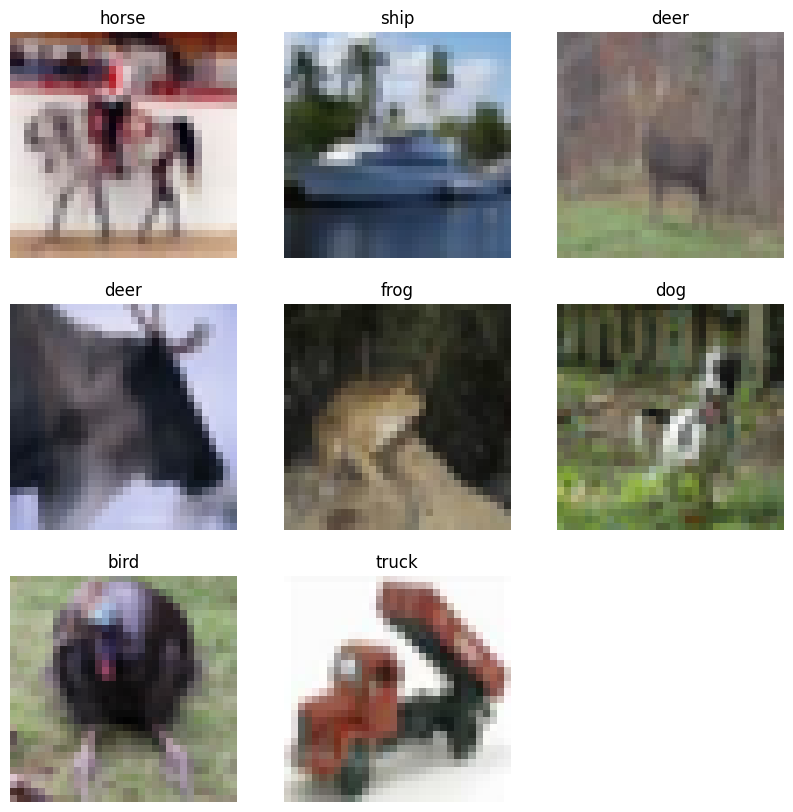

In [18]:
# Visualize the training data by calling the function
visualize_data(train_data)

# Data to Set up for model input _v2

In [19]:
# --- Preprocessing function ---
def preprocess(image, label):
    # resize image
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # normalize to [0,1]
    image = tf.cast(image, tf.float32) / 255.0
    # one-hot encode labels
    label = tf.one_hot(label, depth=10)
    return image, label

In [20]:
# --- Build train/test pipelines ---
train_ds = (
    train_data
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1000, seed=SEED)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [21]:
test_ds = (
    test_data
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Augmentation Layer

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="augmentation")

#Function to run model with different set ups

In [23]:
def run_experiment_v3(model, model_name, base_model,
                   train_ds, test_ds,
                   frozen_lr=1e-3, fine_lr=1e-5,
                   frozen_epochs=10, fine_epochs=10,
                   use_early_stop=True, monitor="val_loss", patience=3, min_delta=0.0,
                   folder_path = folder_path):

    """
    Runs a two-phase experiment:
    1. Train head with frozen base
    2. Fine-tune with base unfrozen

    Args:
        model: compiled keras model with base_model included
        model_name: name string
        base_model: the backbone (e.g., ResNet50)
        train_images, train_labels: training data
        test_images, test_labels: validation/test data
        batch_size: training batch size
        frozen_lr: learning rate during frozen training
        fine_lr: learning rate during fine-tuning
        frozen_epochs: epochs for frozen training
        fine_epochs: epochs for fine-tuning
    """
# --- Timestamp for all saved files ---
    timestamp = time.strftime("%Y%m%d-%H%M%S")

    # --- Callbacks for frozen head ---
    callbacks_frozen = []
    if use_early_stop and frozen_epochs > 1:
        callbacks_frozen.append(EarlyStopping(
            monitor=monitor, patience=patience, min_delta=min_delta, restore_best_weights=True
        ))

    # --- Phase 1: Train head (frozen base) ---
    base_model.trainable = False
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=frozen_lr),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    if frozen_epochs > 0:
        history_frozen = model.fit(
            train_ds,
            validation_data=test_ds,
            epochs=frozen_epochs, verbose=2,
            callbacks=callbacks_frozen
        )
        """history = model.fit(train_images, train_labels,
                            validation_data=(test_images, test_labels),
                            epochs=frozen_epochs, batch_size=batch_size,
                            verbose=2, callbacks=callbacks_frozen)"""

        # --- Save frozen history ---
        hist_frozen = pd.DataFrame(history_frozen.history)
        frozen_hist_path = os.path.join(folder_path, f"{model_name}_history_frozen_{timestamp}.pkl")
        with open(frozen_hist_path, "wb") as f:
            pickle.dump(history_frozen.history, f)
        del history_frozen
    else:
        hist_frozen = pd.DataFrame()  # empty DataFrame if skipped

    # --- Save frozen model ---
    frozen_model_path = os.path.join(folder_path, f"{model_name}_frozen_{timestamp}.keras")
    model.save(frozen_model_path)
    print(f"Frozen model saved to {frozen_model_path}")
    # Remove any temporary copy in runtime (if created)
    if os.path.exists(f"{model_name}_frozen_{timestamp}.keras"):
        os.remove(f"{model_name}_frozen_{timestamp}.keras")


  #---------------------------------------------------------------------------------------
    # --- Phase 2: Fine-tuning (last block only) ---
    for layer in base_model.layers:
        layer.trainable = layer.name.startswith('conv4') or layer.name.startswith('conv5')

    trainable_layers = []
    print("Trainable layers for fine-tuning:")
    for layer in base_model.layers:
        if layer.trainable:
            trainable_layers.append(layer.name)
            print(layer.name)

    # --- Callbacks for fine-tuning ---
    callbacks_fine = []
    if use_early_stop:
        callbacks_fine.append(EarlyStopping(
            monitor=monitor, patience=patience+2, restore_best_weights=True
        ))

    callbacks_fine.extend([
        ReduceLROnPlateau(monitor=monitor, factor=0.5, patience=patience, verbose=1),
        CSVLogger(os.path.join(folder_path, f'{model_name}_finetune_log_{timestamp}.csv'), append=False),
        ModelCheckpoint(os.path.join(folder_path, f"{model_name}_best_finetune_{timestamp}.keras"),
                        monitor=monitor, save_best_only=True, verbose=1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=fine_lr),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    history_fine = model.fit(
        train_ds,
        validation_data=test_ds,
        epochs=fine_epochs, verbose=2,
        callbacks=callbacks_fine
    )
    """history_fine = model.fit(train_images, train_labels,
                             validation_data=(test_images, test_labels),
                             epochs=fine_epochs, batch_size=batch_size,
                             verbose=2, callbacks=callbacks_fine)"""

    # --- Save fine-tuning history ---
    hist_fine = pd.DataFrame(history_fine.history)
    fine_hist_path = os.path.join(folder_path, f"{model_name}_history_fine_{timestamp}.pkl")
    with open(fine_hist_path, "wb") as f:
        pickle.dump(history_fine.history, f)
    del history_fine

    # Cleanup any local checkpoint duplicates
    tmp_ckpt = f"{model_name}_best_finetune_{timestamp}.keras"
    if os.path.exists(tmp_ckpt):
        os.remove(tmp_ckpt)


    # --- Plot results ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    if not hist_frozen.empty:
        ax1.plot(hist_frozen['accuracy'], label='Train Acc (frozen)', color='blue', linestyle='--', marker='o')
        ax1.plot(hist_frozen['val_accuracy'], label='Val Acc (frozen)', color='green', linestyle='--', marker='o')
        ax2.plot(hist_frozen['loss'], label='Train Loss (frozen)', color='orange', linestyle='--', marker='o')
        ax2.plot(hist_frozen['val_loss'], label='Val Loss (frozen)', color='red', linestyle='--', marker='o')

    ax1.plot(hist_fine['accuracy'], label='Train Acc (fine-tune)', color='navy', linestyle='-', marker='x')
    ax1.plot(hist_fine['val_accuracy'], label='Val Acc (fine-tune)', color='darkgreen', linestyle='-', marker='x')
    ax2.plot(hist_fine['loss'], label='Train Loss (fine-tune)', color='darkorange', linestyle='-', marker='x')
    ax2.plot(hist_fine['val_loss'], label='Val Loss (fine-tune)', color='darkred', linestyle='-', marker='x')

    ax1.set_title('Accuracy over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.set_title('Loss over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # --- Collect results ---
    results = {
        "model_name": model_name,
        "timestamp": timestamp,
        "history_frozen": hist_frozen,
        "history_fine": hist_fine,
        "frozen_model_path": frozen_model_path,
        "fine_model_path": os.path.join(folder_path, f"{model_name}_best_finetune_{timestamp}.keras"),
        "fine_lr": fine_lr,
        "fine_epochs": fine_epochs,
        "use_early_stop": use_early_stop,
        "monitor": monitor,
        "patience": patience,
        "trainable_layers": trainable_layers
    }

    # --- Memory cleanup ---
    K.clear_session()
    del model
    del base_model
    gc.collect()

    return results



#Run function run_experiment_v3

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
base_model.trainable = False

"""model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    #layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))

    layers.Dense(16, activation='relu'),
    layers.Dense(10, activation='softmax')
])

results = run_experiment_v3(model, "16relu_test", base_model,
                            train_ds, test_ds,frozen_epochs=2, fine_epochs=2)

save_experiment_results(results)"""

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),  # L2 penalty
    layers.BatchNormalization(),  # normalize output
    layers.ReLU(),                # separate ReLU
    layers.Dropout(0.2),           # dropout for regularization,

    layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),  # L2 penalty
    layers.BatchNormalization(),  # normalize output
    layers.ReLU(),                # separate ReLU
    layers.Dropout(0.2),           # dropout for regularization,

    layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),  # L2 penalty
    layers.BatchNormalization(),  # normalize output
    layers.ReLU(),                # separate ReLU
    layers.Dropout(0.2),           # dropout for regularization,

    layers.Dense(10, activation='softmax')
])

results = run_experiment_v4(model, "ResNet50_GAP_FC128-64-32_BN_ReLU_Drop0.2_L2", base_model,
                            train_ds, test_ds,fine_lr=1e-4)

save_experiment_results(results)

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),  # L2 penalty
    layers.BatchNormalization(),  # normalize output
    layers.ReLU(),                # separate ReLU
    layers.Dropout(0.2),           # dropout for regularization,

    layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),  # L2 penalty
    layers.BatchNormalization(),  # normalize output
    layers.ReLU(),                # separate ReLU
    layers.Dropout(0.2),           # dropout for regularization,

    layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),  # L2 penalty
    layers.BatchNormalization(),  # normalize output
    layers.ReLU(),                # separate ReLU
    layers.Dropout(0.2),           # dropout for regularization,

    layers.Dense(10, activation='softmax')
])

results = run_experiment_v4(model, "ResNet50_GAP_FC128-64-32_BN_ReLU_Drop0.2_L2", base_model,
                            train_ds, test_ds,fine_lr=1e-4)

save_experiment_results(results)

#Run Function  run_experiment_v2

## v2-Run3

Epoch 1/10
625/625 - 35s - 56ms/step - accuracy: 0.0980 - loss: 2.3118 - val_accuracy: 0.1000 - val_loss: 2.3030
Epoch 2/10
625/625 - 15s - 24ms/step - accuracy: 0.1038 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3030
Epoch 3/10
625/625 - 25s - 40ms/step - accuracy: 0.1000 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 4/10
625/625 - 14s - 23ms/step - accuracy: 0.1045 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 5/10
625/625 - 14s - 22ms/step - accuracy: 0.1042 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3030
Epoch 6/10
625/625 - 14s - 23ms/step - accuracy: 0.1041 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3030
Frozen model saved to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu_dropout0.5-64relu_frozen_20250822-220107.keras
Trainable layers for fine-tuning:
conv5_block1_1_conv
conv5_block1_1_bn
conv5_block1_1_relu
conv5_block1_2_conv
conv5_block1_2_bn
conv5

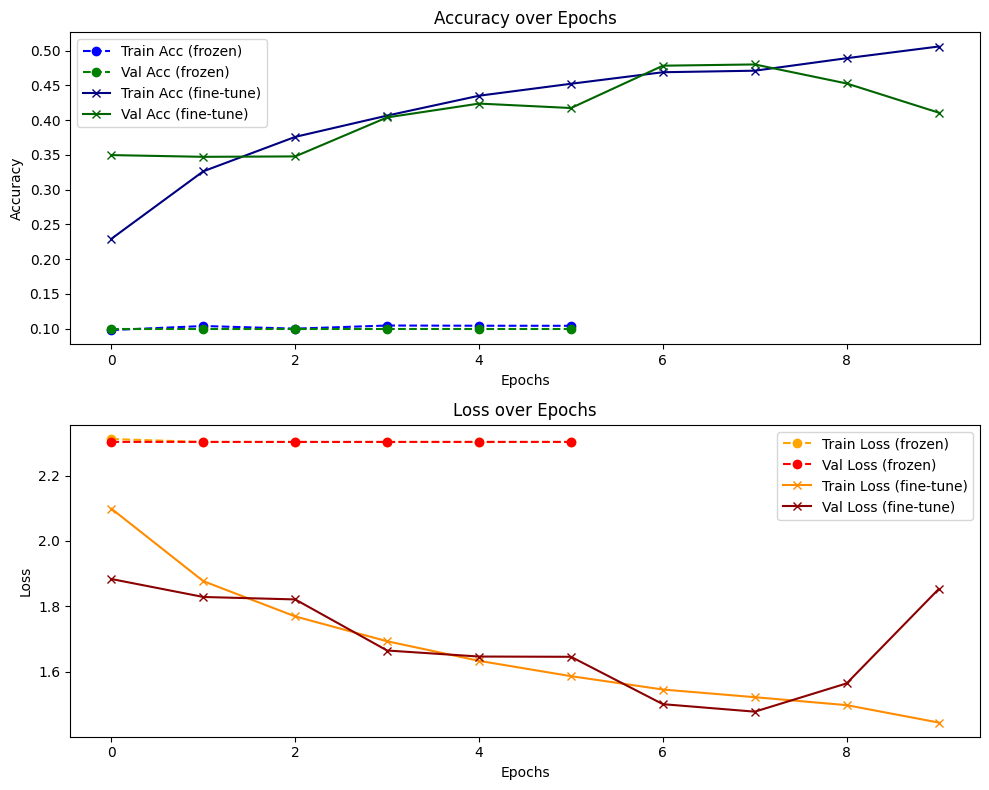

Experiment results saved to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/experiment_results.csv
                  model_name  frozen_accuracy_pct  fine_accuracy_pct  \
0  128relu_dropout0.5-64relu                  0.1             0.4801   

   frozen_loss  fine_loss  
0     2.302869   1.477091  


In [50]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

results = run_experiment_v3(model, "128relu_dropout0.5-64relu", base_model,
                            train_ds, test_ds)

save_experiment_results(results)


"""Epoch 1/10
625/625 - 35s - 56ms/step - accuracy: 0.0980 - loss: 2.3118 - val_accuracy: 0.1000 - val_loss: 2.3030
Epoch 2/10
625/625 - 15s - 24ms/step - accuracy: 0.1038 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3030
Epoch 3/10
625/625 - 25s - 40ms/step - accuracy: 0.1000 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 4/10
625/625 - 14s - 23ms/step - accuracy: 0.1045 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 5/10
625/625 - 14s - 22ms/step - accuracy: 0.1042 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3030
Epoch 6/10
625/625 - 14s - 23ms/step - accuracy: 0.1041 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3030
Frozen model saved to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu_dropout0.5-64relu_frozen_20250822-220107.keras
Trainable layers for fine-tuning:
conv5_block1_1_conv
conv5_block1_1_bn
conv5_block1_1_relu
conv5_block1_2_conv
conv5_block1_2_bn
conv5_block1_2_relu
conv5_block1_0_conv
conv5_block1_3_conv
conv5_block1_0_bn
conv5_block1_3_bn
conv5_block1_add
conv5_block1_out
conv5_block2_1_conv
conv5_block2_1_bn
conv5_block2_1_relu
conv5_block2_2_conv
conv5_block2_2_bn
conv5_block2_2_relu
conv5_block2_3_conv
conv5_block2_3_bn
conv5_block2_add
conv5_block2_out
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
Epoch 1/10

Epoch 1: val_loss improved from inf to 1.88318, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu_dropout0.5-64relu_best_finetune_20250822-220107.keras
625/625 - 63s - 101ms/step - accuracy: 0.2293 - loss: 2.0985 - val_accuracy: 0.3497 - val_loss: 1.8832 - learning_rate: 1.0000e-05
Epoch 2/10

Epoch 2: val_loss improved from 1.88318 to 1.82822, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu_dropout0.5-64relu_best_finetune_20250822-220107.keras
625/625 - 26s - 42ms/step - accuracy: 0.3264 - loss: 1.8767 - val_accuracy: 0.3472 - val_loss: 1.8282 - learning_rate: 1.0000e-05
Epoch 3/10

Epoch 3: val_loss improved from 1.82822 to 1.82071, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu_dropout0.5-64relu_best_finetune_20250822-220107.keras
625/625 - 26s - 42ms/step - accuracy: 0.3759 - loss: 1.7687 - val_accuracy: 0.3478 - val_loss: 1.8207 - learning_rate: 1.0000e-05
Epoch 4/10

Epoch 4: val_loss improved from 1.82071 to 1.66432, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu_dropout0.5-64relu_best_finetune_20250822-220107.keras
625/625 - 37s - 60ms/step - accuracy: 0.4065 - loss: 1.6926 - val_accuracy: 0.4039 - val_loss: 1.6643 - learning_rate: 1.0000e-05
Epoch 5/10

Epoch 5: val_loss improved from 1.66432 to 1.64585, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu_dropout0.5-64relu_best_finetune_20250822-220107.keras
625/625 - 24s - 38ms/step - accuracy: 0.4351 - loss: 1.6327 - val_accuracy: 0.4238 - val_loss: 1.6459 - learning_rate: 1.0000e-05
Epoch 6/10

Epoch 6: val_loss improved from 1.64585 to 1.64509, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu_dropout0.5-64relu_best_finetune_20250822-220107.keras
625/625 - 39s - 63ms/step - accuracy: 0.4523 - loss: 1.5858 - val_accuracy: 0.4174 - val_loss: 1.6451 - learning_rate: 1.0000e-05
Epoch 7/10

Epoch 7: val_loss improved from 1.64509 to 1.50005, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu_dropout0.5-64relu_best_finetune_20250822-220107.keras
625/625 - 42s - 67ms/step - accuracy: 0.4689 - loss: 1.5449 - val_accuracy: 0.4783 - val_loss: 1.5001 - learning_rate: 1.0000e-05
Epoch 8/10

Epoch 8: val_loss improved from 1.50005 to 1.47709, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu_dropout0.5-64relu_best_finetune_20250822-220107.keras
625/625 - 25s - 41ms/step - accuracy: 0.4711 - loss: 1.5214 - val_accuracy: 0.4801 - val_loss: 1.4771 - learning_rate: 1.0000e-05
Epoch 9/10

Epoch 9: val_loss did not improve from 1.47709
625/625 - 24s - 38ms/step - accuracy: 0.4891 - loss: 1.4970 - val_accuracy: 0.4527 - val_loss: 1.5638 - learning_rate: 1.0000e-05
Epoch 10/10

Epoch 10: val_loss did not improve from 1.47709
625/625 - 21s - 33ms/step - accuracy: 0.5059 - loss: 1.4438 - val_accuracy: 0.4108 - val_loss: 1.8523 - learning_rate: 1.0000e-05

Experiment results saved to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/experiment_results.csv
                  model_name  frozen_accuracy_pct  fine_accuracy_pct  \
0  128relu_dropout0.5-64relu                  0.1             0.4801

   frozen_loss  fine_loss
0     2.302869   1.477091  """

## v2-Run4

Epoch 1/10
625/625 - 43s - 69ms/step - accuracy: 0.1032 - loss: 2.3058 - val_accuracy: 0.1000 - val_loss: 2.3093
Epoch 2/10
625/625 - 38s - 61ms/step - accuracy: 0.1441 - loss: 2.2461 - val_accuracy: 0.1631 - val_loss: 2.1808
Epoch 3/10
625/625 - 28s - 44ms/step - accuracy: 0.2012 - loss: 2.1150 - val_accuracy: 0.2328 - val_loss: 2.0105
Epoch 4/10
625/625 - 24s - 39ms/step - accuracy: 0.2262 - loss: 2.0288 - val_accuracy: 0.2522 - val_loss: 1.9677
Epoch 5/10
625/625 - 26s - 42ms/step - accuracy: 0.2451 - loss: 1.9874 - val_accuracy: 0.2576 - val_loss: 1.9461
Epoch 6/10
625/625 - 24s - 39ms/step - accuracy: 0.2464 - loss: 1.9841 - val_accuracy: 0.2722 - val_loss: 1.9142
Epoch 7/10
625/625 - 33s - 53ms/step - accuracy: 0.2616 - loss: 1.9448 - val_accuracy: 0.2657 - val_loss: 1.9133
Epoch 8/10
625/625 - 24s - 39ms/step - accuracy: 0.2568 - loss: 1.9474 - val_accuracy: 0.2788 - val_loss: 1.9017
Epoch 9/10
625/625 - 41s - 66ms/step - accuracy: 0.2582 - loss: 1.9307 - val_accuracy: 0.2674 - 

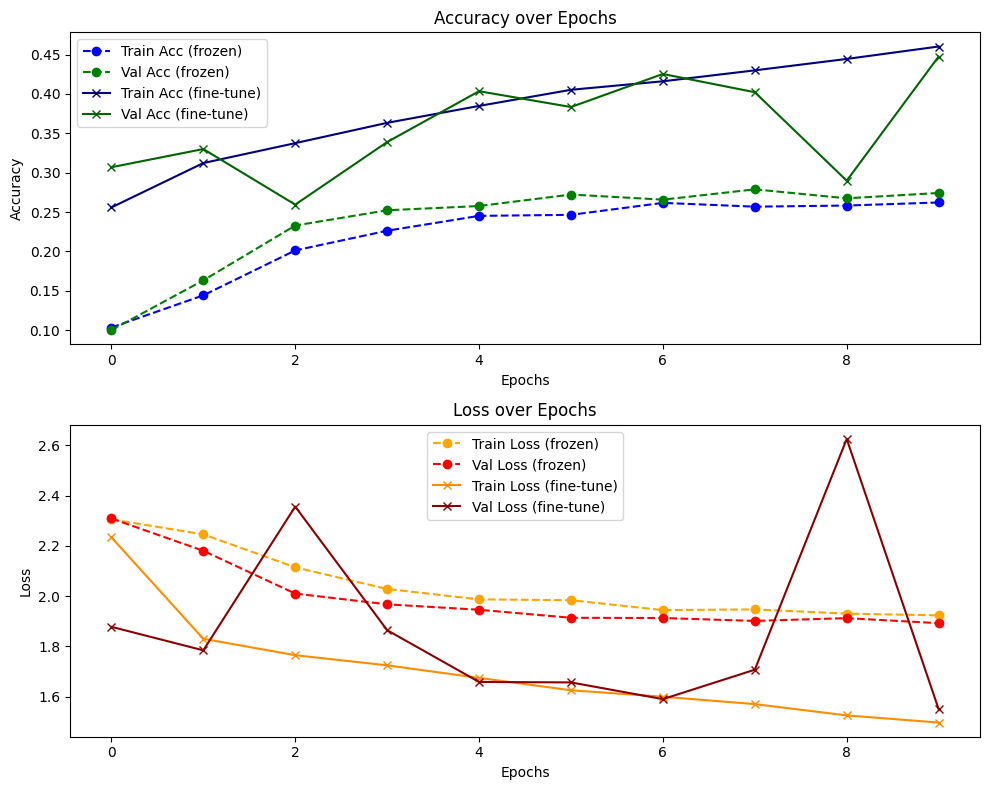

Experiment results saved to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/experiment_results.csv
                          model_name  frozen_accuracy_pct  fine_accuracy_pct  \
0  256relu-128relu_dropout0.3-64relu               0.2788             0.4476   

   frozen_loss  fine_loss  
0     1.892741   1.550746  


In [51]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

results = run_experiment_v3(model, "256relu-128relu_dropout0.3-64relu", base_model,
                            train_ds, test_ds)

save_experiment_results(results)
"""Epoch 1/10
625/625 - 43s - 69ms/step - accuracy: 0.1032 - loss: 2.3058 - val_accuracy: 0.1000 - val_loss: 2.3093
Epoch 2/10
625/625 - 38s - 61ms/step - accuracy: 0.1441 - loss: 2.2461 - val_accuracy: 0.1631 - val_loss: 2.1808
Epoch 3/10
625/625 - 28s - 44ms/step - accuracy: 0.2012 - loss: 2.1150 - val_accuracy: 0.2328 - val_loss: 2.0105
Epoch 4/10
625/625 - 24s - 39ms/step - accuracy: 0.2262 - loss: 2.0288 - val_accuracy: 0.2522 - val_loss: 1.9677
Epoch 5/10
625/625 - 26s - 42ms/step - accuracy: 0.2451 - loss: 1.9874 - val_accuracy: 0.2576 - val_loss: 1.9461
Epoch 6/10
625/625 - 24s - 39ms/step - accuracy: 0.2464 - loss: 1.9841 - val_accuracy: 0.2722 - val_loss: 1.9142
Epoch 7/10
625/625 - 33s - 53ms/step - accuracy: 0.2616 - loss: 1.9448 - val_accuracy: 0.2657 - val_loss: 1.9133
Epoch 8/10
625/625 - 24s - 39ms/step - accuracy: 0.2568 - loss: 1.9474 - val_accuracy: 0.2788 - val_loss: 1.9017
Epoch 9/10
625/625 - 41s - 66ms/step - accuracy: 0.2582 - loss: 1.9307 - val_accuracy: 0.2674 - val_loss: 1.9128
Epoch 10/10
625/625 - 25s - 40ms/step - accuracy: 0.2621 - loss: 1.9239 - val_accuracy: 0.2742 - val_loss: 1.8927
Frozen model saved to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/256relu-128relu_dropout0.3-64relu_frozen_20250822-220857.keras
Trainable layers for fine-tuning:
conv5_block1_1_conv
conv5_block1_1_bn
conv5_block1_1_relu
conv5_block1_2_conv
conv5_block1_2_bn
conv5_block1_2_relu
conv5_block1_0_conv
conv5_block1_3_conv
conv5_block1_0_bn
conv5_block1_3_bn
conv5_block1_add
conv5_block1_out
conv5_block2_1_conv
conv5_block2_1_bn
conv5_block2_1_relu
conv5_block2_2_conv
conv5_block2_2_bn
conv5_block2_2_relu
conv5_block2_3_conv
conv5_block2_3_bn
conv5_block2_add
conv5_block2_out
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
Epoch 1/10

Epoch 1: val_loss improved from inf to 1.87825, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/256relu-128relu_dropout0.3-64relu_best_finetune_20250822-220857.keras
625/625 - 64s - 103ms/step - accuracy: 0.2558 - loss: 2.2343 - val_accuracy: 0.3069 - val_loss: 1.8783 - learning_rate: 1.0000e-05
Epoch 2/10

Epoch 2: val_loss improved from 1.87825 to 1.78466, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/256relu-128relu_dropout0.3-64relu_best_finetune_20250822-220857.keras
625/625 - 40s - 63ms/step - accuracy: 0.3122 - loss: 1.8307 - val_accuracy: 0.3300 - val_loss: 1.7847 - learning_rate: 1.0000e-05
Epoch 3/10

Epoch 3: val_loss did not improve from 1.78466
625/625 - 38s - 61ms/step - accuracy: 0.3375 - loss: 1.7654 - val_accuracy: 0.2594 - val_loss: 2.3566 - learning_rate: 1.0000e-05
Epoch 4/10

Epoch 4: val_loss did not improve from 1.78466
625/625 - 37s - 60ms/step - accuracy: 0.3633 - loss: 1.7250 - val_accuracy: 0.3389 - val_loss: 1.8649 - learning_rate: 1.0000e-05
Epoch 5/10

Epoch 5: val_loss improved from 1.78466 to 1.65891, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/256relu-128relu_dropout0.3-64relu_best_finetune_20250822-220857.keras
625/625 - 52s - 83ms/step - accuracy: 0.3848 - loss: 1.6751 - val_accuracy: 0.4035 - val_loss: 1.6589 - learning_rate: 1.0000e-05
Epoch 6/10

Epoch 6: val_loss improved from 1.65891 to 1.65706, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/256relu-128relu_dropout0.3-64relu_best_finetune_20250822-220857.keras
625/625 - 70s - 112ms/step - accuracy: 0.4053 - loss: 1.6258 - val_accuracy: 0.3834 - val_loss: 1.6571 - learning_rate: 1.0000e-05
Epoch 7/10

Epoch 7: val_loss improved from 1.65706 to 1.59061, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/256relu-128relu_dropout0.3-64relu_best_finetune_20250822-220857.keras
625/625 - 40s - 64ms/step - accuracy: 0.4161 - loss: 1.6001 - val_accuracy: 0.4254 - val_loss: 1.5906 - learning_rate: 1.0000e-05
Epoch 8/10

Epoch 8: val_loss did not improve from 1.59061
625/625 - 38s - 61ms/step - accuracy: 0.4300 - loss: 1.5708 - val_accuracy: 0.4022 - val_loss: 1.7076 - learning_rate: 1.0000e-05
Epoch 9/10

Epoch 9: val_loss did not improve from 1.59061
625/625 - 37s - 58ms/step - accuracy: 0.4445 - loss: 1.5257 - val_accuracy: 0.2898 - val_loss: 2.6254 - learning_rate: 1.0000e-05
Epoch 10/10

Epoch 10: val_loss improved from 1.59061 to 1.55075, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/256relu-128relu_dropout0.3-64relu_best_finetune_20250822-220857.keras
625/625 - 48s - 76ms/step - accuracy: 0.4603 - loss: 1.4974 - val_accuracy: 0.4476 - val_loss: 1.5507 - learning_rate: 1.0000e-05

Experiment results saved to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/experiment_results.csv
                          model_name  frozen_accuracy_pct  fine_accuracy_pct  \
0  256relu-128relu_dropout0.3-64relu               0.2788             0.4476

   frozen_loss  fine_loss
0     1.892741   1.550746  """

## v2-Run5

Epoch 1/10
625/625 - 41s - 65ms/step - accuracy: 0.0986 - loss: 2.3119 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 2/10
625/625 - 24s - 38ms/step - accuracy: 0.1077 - loss: 2.2946 - val_accuracy: 0.1250 - val_loss: 2.2732
Epoch 3/10
625/625 - 24s - 38ms/step - accuracy: 0.1446 - loss: 2.2375 - val_accuracy: 0.1522 - val_loss: 2.2374
Epoch 4/10
625/625 - 41s - 65ms/step - accuracy: 0.1878 - loss: 2.1314 - val_accuracy: 0.2461 - val_loss: 2.0006
Epoch 5/10
625/625 - 42s - 67ms/step - accuracy: 0.2319 - loss: 2.0213 - val_accuracy: 0.2573 - val_loss: 1.9676
Epoch 6/10
625/625 - 24s - 38ms/step - accuracy: 0.2410 - loss: 1.9930 - val_accuracy: 0.2595 - val_loss: 1.9408
Epoch 7/10
625/625 - 26s - 42ms/step - accuracy: 0.2407 - loss: 1.9911 - val_accuracy: 0.2266 - val_loss: 2.0341
Epoch 8/10
625/625 - 35s - 56ms/step - accuracy: 0.2493 - loss: 1.9611 - val_accuracy: 0.2301 - val_loss: 2.0089
Epoch 9/10
625/625 - 24s - 38ms/step - accuracy: 0.2541 - loss: 1.9568 - val_accuracy: 0.2431 - 

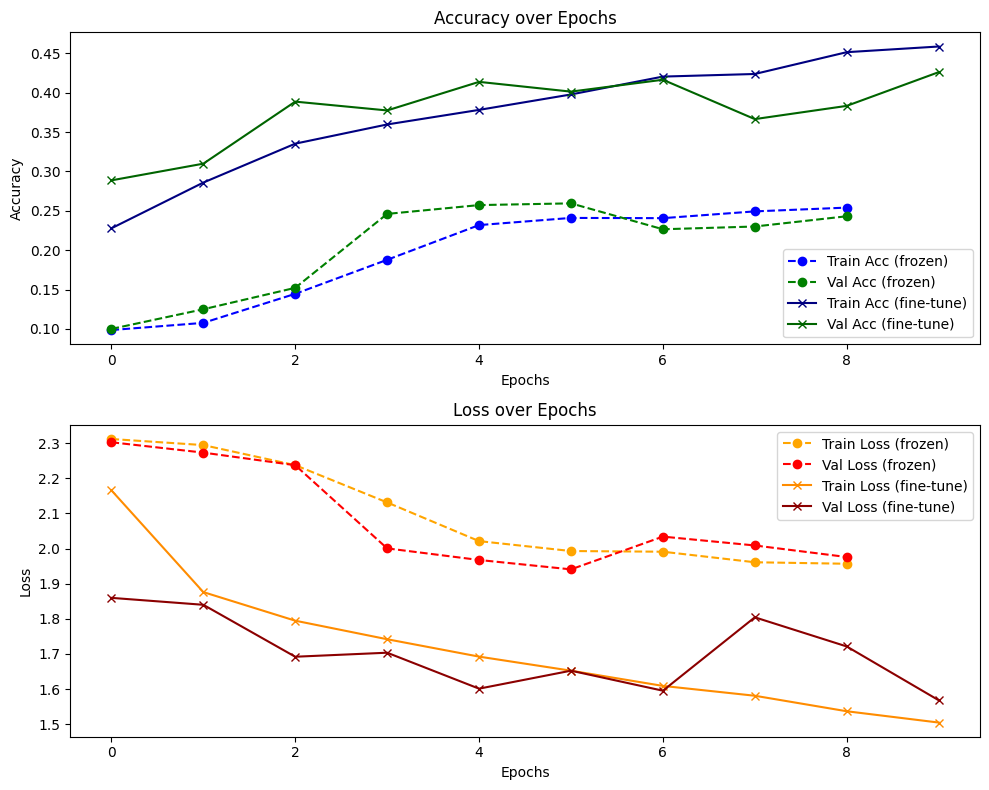

Experiment results saved to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/experiment_results.csv
                           model_name  frozen_accuracy_pct  fine_accuracy_pct  \
0  512relu-256relu_dropout0.5-128relu               0.2595             0.4261   

   frozen_loss  fine_loss  
0     1.940841   1.568326  


In [52]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

results = run_experiment_v3(model, "512relu-256relu_dropout0.5-128relu", base_model,
                            train_ds, test_ds)


save_experiment_results(results)
"""Epoch 1/10
625/625 - 41s - 65ms/step - accuracy: 0.0986 - loss: 2.3119 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 2/10
625/625 - 24s - 38ms/step - accuracy: 0.1077 - loss: 2.2946 - val_accuracy: 0.1250 - val_loss: 2.2732
Epoch 3/10
625/625 - 24s - 38ms/step - accuracy: 0.1446 - loss: 2.2375 - val_accuracy: 0.1522 - val_loss: 2.2374
Epoch 4/10
625/625 - 41s - 65ms/step - accuracy: 0.1878 - loss: 2.1314 - val_accuracy: 0.2461 - val_loss: 2.0006
Epoch 5/10
625/625 - 42s - 67ms/step - accuracy: 0.2319 - loss: 2.0213 - val_accuracy: 0.2573 - val_loss: 1.9676
Epoch 6/10
625/625 - 24s - 38ms/step - accuracy: 0.2410 - loss: 1.9930 - val_accuracy: 0.2595 - val_loss: 1.9408
Epoch 7/10
625/625 - 26s - 42ms/step - accuracy: 0.2407 - loss: 1.9911 - val_accuracy: 0.2266 - val_loss: 2.0341
Epoch 8/10
625/625 - 35s - 56ms/step - accuracy: 0.2493 - loss: 1.9611 - val_accuracy: 0.2301 - val_loss: 2.0089
Epoch 9/10
625/625 - 24s - 38ms/step - accuracy: 0.2541 - loss: 1.9568 - val_accuracy: 0.2431 - val_loss: 1.9760
Frozen model saved to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/512relu-256relu_dropout0.5-128relu_frozen_20250822-222226.keras
Trainable layers for fine-tuning:
conv5_block1_1_conv
conv5_block1_1_bn
conv5_block1_1_relu
conv5_block1_2_conv
conv5_block1_2_bn
conv5_block1_2_relu
conv5_block1_0_conv
conv5_block1_3_conv
conv5_block1_0_bn
conv5_block1_3_bn
conv5_block1_add
conv5_block1_out
conv5_block2_1_conv
conv5_block2_1_bn
conv5_block2_1_relu
conv5_block2_2_conv
conv5_block2_2_bn
conv5_block2_2_relu
conv5_block2_3_conv
conv5_block2_3_bn
conv5_block2_add
conv5_block2_out
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
Epoch 1/10

Epoch 1: val_loss improved from inf to 1.85973, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/512relu-256relu_dropout0.5-128relu_best_finetune_20250822-222226.keras
625/625 - 67s - 107ms/step - accuracy: 0.2278 - loss: 2.1659 - val_accuracy: 0.2887 - val_loss: 1.8597 - learning_rate: 1.0000e-05
Epoch 2/10

Epoch 2: val_loss improved from 1.85973 to 1.83998, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/512relu-256relu_dropout0.5-128relu_best_finetune_20250822-222226.keras
625/625 - 69s - 111ms/step - accuracy: 0.2859 - loss: 1.8761 - val_accuracy: 0.3099 - val_loss: 1.8400 - learning_rate: 1.0000e-05
Epoch 3/10

Epoch 3: val_loss improved from 1.83998 to 1.69211, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/512relu-256relu_dropout0.5-128relu_best_finetune_20250822-222226.keras
625/625 - 40s - 64ms/step - accuracy: 0.3353 - loss: 1.7947 - val_accuracy: 0.3887 - val_loss: 1.6921 - learning_rate: 1.0000e-05
Epoch 4/10

Epoch 4: val_loss did not improve from 1.69211
625/625 - 49s - 78ms/step - accuracy: 0.3597 - loss: 1.7419 - val_accuracy: 0.3775 - val_loss: 1.7036 - learning_rate: 1.0000e-05
Epoch 5/10

Epoch 5: val_loss improved from 1.69211 to 1.60125, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/512relu-256relu_dropout0.5-128relu_best_finetune_20250822-222226.keras
625/625 - 48s - 76ms/step - accuracy: 0.3782 - loss: 1.6924 - val_accuracy: 0.4138 - val_loss: 1.6012 - learning_rate: 1.0000e-05
Epoch 6/10

Epoch 6: val_loss did not improve from 1.60125
625/625 - 39s - 62ms/step - accuracy: 0.3978 - loss: 1.6524 - val_accuracy: 0.4014 - val_loss: 1.6524 - learning_rate: 1.0000e-05
Epoch 7/10

Epoch 7: val_loss improved from 1.60125 to 1.59543, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/512relu-256relu_dropout0.5-128relu_best_finetune_20250822-222226.keras
625/625 - 40s - 64ms/step - accuracy: 0.4205 - loss: 1.6091 - val_accuracy: 0.4165 - val_loss: 1.5954 - learning_rate: 1.0000e-05
Epoch 8/10

Epoch 8: val_loss did not improve from 1.59543
625/625 - 39s - 63ms/step - accuracy: 0.4238 - loss: 1.5811 - val_accuracy: 0.3665 - val_loss: 1.8044 - learning_rate: 1.0000e-05
Epoch 9/10

Epoch 9: val_loss did not improve from 1.59543
625/625 - 39s - 62ms/step - accuracy: 0.4515 - loss: 1.5369 - val_accuracy: 0.3833 - val_loss: 1.7214 - learning_rate: 1.0000e-05
Epoch 10/10

Epoch 10: val_loss improved from 1.59543 to 1.56833, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/512relu-256relu_dropout0.5-128relu_best_finetune_20250822-222226.keras
625/625 - 48s - 77ms/step - accuracy: 0.4587 - loss: 1.5048 - val_accuracy: 0.4261 - val_loss: 1.5683 - learning_rate: 1.0000e-05

Experiment results saved to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/experiment_results.csv
                           model_name  frozen_accuracy_pct  fine_accuracy_pct  \
0  512relu-256relu_dropout0.5-128relu               0.2595             0.4261

   frozen_loss  fine_loss
0     1.940841   1.568326 """

#spaceer

# Previous Runs

## Run 1

In [137]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

results = run_experiment(model, "128relu", base_model, train_images, train_labels, test_images, test_labels)
all_results.append(results)

df_results = pd.DataFrame(all_results)
print(df_results[["model_name",
                  "frozen_accuracy_pct", "fine_accuracy_pct",
                  "frozen_loss", "fine_loss"]])
"""Epoch 1/10
157/157 - 92s - 584ms/step - accuracy: 0.1580 - loss: 2.2858 - val_accuracy: 0.2104 - val_loss: 2.1576
Epoch 2/10
157/157 - 140s - 892ms/step - accuracy: 0.2233 - loss: 2.1229 - val_accuracy: 0.2495 - val_loss: 2.0642
Epoch 3/10
157/157 - 78s - 500ms/step - accuracy: 0.2550 - loss: 2.0463 - val_accuracy: 0.2684 - val_loss: 2.0014
Epoch 4/10
157/157 - 78s - 497ms/step - accuracy: 0.2723 - loss: 1.9963 - val_accuracy: 0.2912 - val_loss: 1.9538
Epoch 5/10
157/157 - 84s - 536ms/step - accuracy: 0.2810 - loss: 1.9645 - val_accuracy: 0.3134 - val_loss: 1.9120
Epoch 6/10
157/157 - 80s - 510ms/step - accuracy: 0.2943 - loss: 1.9322 - val_accuracy: 0.3194 - val_loss: 1.8891
Epoch 7/10
157/157 - 79s - 502ms/step - accuracy: 0.3001 - loss: 1.9130 - val_accuracy: 0.3208 - val_loss: 1.8721
Epoch 8/10
157/157 - 80s - 512ms/step - accuracy: 0.3088 - loss: 1.8935 - val_accuracy: 0.3265 - val_loss: 1.8590
Epoch 9/10
157/157 - 81s - 519ms/step - accuracy: 0.3153 - loss: 1.8767 - val_accuracy: 0.3354 - val_loss: 1.8454
Epoch 10/10
157/157 - 82s - 520ms/step - accuracy: 0.3254 - loss: 1.8597 - val_accuracy: 0.3331 - val_loss: 1.8410
Epoch 1/10
157/157 - 746s - 5s/step - accuracy: 0.1348 - loss: 4.3706 - val_accuracy: 0.0898 - val_loss: 16.5716
Epoch 2/10
157/157 - 695s - 4s/step - accuracy: 0.3620 - loss: 1.9978 - val_accuracy: 0.0983 - val_loss: 164.6980
Epoch 3/10
157/157 - 752s - 5s/step - accuracy: 0.6174 - loss: 1.1833 - val_accuracy: 0.1028 - val_loss: 196.4685
Epoch 4/10
157/157 - 708s - 5s/step - accuracy: 0.7900 - loss: 0.7861 - val_accuracy: 0.0925 - val_loss: 44.6628
Epoch 5/10
157/157 - 703s - 4s/step - accuracy: 0.8813 - loss: 0.5491 - val_accuracy: 0.1420 - val_loss: 8.9480
Epoch 6/10
157/157 - 700s - 4s/step - accuracy: 0.9406 - loss: 0.3923 - val_accuracy: 0.2001 - val_loss: 3.4055
Epoch 7/10
157/157 - 745s - 5s/step - accuracy: 0.9704 - loss: 0.2834 - val_accuracy: 0.2505 - val_loss: 2.9941
Epoch 8/10
157/157 - 750s - 5s/step - accuracy: 0.9844 - loss: 0.2102 - val_accuracy: 0.2686 - val_loss: 2.9806
Epoch 9/10
157/157 - 745s - 5s/step - accuracy: 0.9913 - loss: 0.1586 - val_accuracy: 0.2775 - val_loss: 2.9781
Epoch 10/10
157/157 - 728s - 5s/step - accuracy: 0.9959 - loss: 0.1196 - val_accuracy: 0.2842 - val_loss: 2.9760
---------------------------------------------------------------------------"""

Epoch 1/10
157/157 - 92s - 584ms/step - accuracy: 0.1580 - loss: 2.2858 - val_accuracy: 0.2104 - val_loss: 2.1576
Epoch 2/10
157/157 - 140s - 892ms/step - accuracy: 0.2233 - loss: 2.1229 - val_accuracy: 0.2495 - val_loss: 2.0642
Epoch 3/10
157/157 - 78s - 500ms/step - accuracy: 0.2550 - loss: 2.0463 - val_accuracy: 0.2684 - val_loss: 2.0014
Epoch 4/10
157/157 - 78s - 497ms/step - accuracy: 0.2723 - loss: 1.9963 - val_accuracy: 0.2912 - val_loss: 1.9538
Epoch 5/10
157/157 - 84s - 536ms/step - accuracy: 0.2810 - loss: 1.9645 - val_accuracy: 0.3134 - val_loss: 1.9120
Epoch 6/10
157/157 - 80s - 510ms/step - accuracy: 0.2943 - loss: 1.9322 - val_accuracy: 0.3194 - val_loss: 1.8891
Epoch 7/10
157/157 - 79s - 502ms/step - accuracy: 0.3001 - loss: 1.9130 - val_accuracy: 0.3208 - val_loss: 1.8721
Epoch 8/10
157/157 - 80s - 512ms/step - accuracy: 0.3088 - loss: 1.8935 - val_accuracy: 0.3265 - val_loss: 1.8590
Epoch 9/10
157/157 - 81s - 519ms/step - accuracy: 0.3153 - loss: 1.8767 - val_accuracy:

KeyError: "['frozen_accuracy', 'fine_accuracy'] not in index"

In [138]:
print(df_results[["model_name",
                  "frozen_accuracy_pct", "fine_accuracy_pct",
                  "frozen_loss", "fine_loss"]])
"""[ ]
print(df_results[["model_name",
                  "frozen_accuracy_pct", "fine_accuracy_pct",
                  "frozen_loss", "fine_loss"]])

  model_name  frozen_accuracy_pct  fine_accuracy_pct  frozen_loss  fine_loss
0    128relu            33.309999          28.420001     1.840974   2.976006
"""

  model_name  frozen_accuracy_pct  fine_accuracy_pct  frozen_loss  fine_loss
0    128relu            33.309999          28.420001     1.840974   2.976006


## Run 2

In [18]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(10, activation='softmax')
])

results = run_experiment(model, "128relu-16relu", base_model, train_images, train_labels, test_images, test_labels)
all_results.append(results)

df_results = pd.DataFrame(all_results)
print(df_results[["model_name",
                  "frozen_accuracy_pct", "fine_accuracy_pct",
                  "frozen_loss", "fine_loss"]])
"""Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
157/157 - 136s - 863ms/step - accuracy: 0.0946 - loss: 2.3137 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 2/10
157/157 - 98s - 621ms/step - accuracy: 0.1018 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 3/10
157/157 - 140s - 891ms/step - accuracy: 0.1052 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 4/10
157/157 - 81s - 513ms/step - accuracy: 0.1052 - loss: 2.3025 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 5/10
157/157 - 81s - 517ms/step - accuracy: 0.1052 - loss: 2.3025 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 6/10
157/157 - 80s - 508ms/step - accuracy: 0.1052 - loss: 2.3025 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 7/10
157/157 - 81s - 514ms/step - accuracy: 0.1052 - loss: 2.3025 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 8/10
157/157 - 81s - 517ms/step - accuracy: 0.1052 - loss: 2.3025 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 9/10
157/157 - 80s - 511ms/step - accuracy: 0.1052 - loss: 2.3025 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 10/10
157/157 - 82s - 521ms/step - accuracy: 0.1052 - loss: 2.3025 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 1/10
157/157 - 795s - 5s/step - accuracy: 0.1178 - loss: 2.4564 - val_accuracy: 0.0971 - val_loss: 3.4888
Epoch 2/10
157/157 - 742s - 5s/step - accuracy: 0.3082 - loss: 1.9219 - val_accuracy: 0.0998 - val_loss: 40.0679
Epoch 3/10
157/157 - 742s - 5s/step - accuracy: 0.4528 - loss: 1.6067 - val_accuracy: 0.0958 - val_loss: 69.9377
Epoch 4/10
157/157 - 749s - 5s/step - accuracy: 0.5606 - loss: 1.3642 - val_accuracy: 0.0668 - val_loss: 15.2064
Epoch 5/10
157/157 - 809s - 5s/step - accuracy: 0.6417 - loss: 1.1571 - val_accuracy: 0.1087 - val_loss: 3.7803
Epoch 6/10
157/157 - 801s - 5s/step - accuracy: 0.7217 - loss: 0.9691 - val_accuracy: 0.1786 - val_loss: 2.4568
Epoch 7/10
157/157 - 796s - 5s/step - accuracy: 0.7854 - loss: 0.8062 - val_accuracy: 0.2465 - val_loss: 2.2692
Epoch 8/10
157/157 - 796s - 5s/step - accuracy: 0.8411 - loss: 0.6617 - val_accuracy: 0.2802 - val_loss: 2.2442
Epoch 9/10
157/157 - 751s - 5s/step - accuracy: 0.8879 - loss: 0.5407 - val_accuracy: 0.2913 - val_loss: 2.2638
Epoch 10/10
157/157 - 794s - 5s/step - accuracy: 0.9221 - loss: 0.4387 - val_accuracy: 0.3024 - val_loss: 2.2810
       model_name  frozen_accuracy_pct  fine_accuracy_pct  frozen_loss  \
0  128relu-16relu                 10.0          30.239999     2.302895

   fine_loss
0   2.280969  """

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
157/157 - 136s - 863ms/step - accuracy: 0.0946 - loss: 2.3137 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 2/10
157/157 - 98s - 621ms/step - accuracy: 0.1018 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 3/10
157/157 - 140s - 891ms/step - accuracy: 0.1052 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 4/10
157/157 - 81s - 513ms/step - accuracy: 0.1052 - loss: 2.3025 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 5/10
157/157 - 81s - 517ms/step - accuracy: 0.1052 - loss: 2.3025 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 6/10
157/157 - 80s - 508ms/step - accuracy: 0.1052 - loss: 2.3025 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 7/10
157/157 - 81s - 514ms/step - accuracy: 0.1052 - loss: 2.3025 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 8/10
157/157 - 81s - 517ms/step - accuracy: 0.1052 - loss: 2.3025 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 9/10
157/157 - 80s - 511ms/st

## Run 3

In [19]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

results = run_experiment(model, "256relu-128relu", base_model, train_images, train_labels, test_images, test_labels)
all_results.append(results)

# display results so far
df_results = pd.DataFrame(all_results)
print(df_results[["model_name",
                  "frozen_accuracy_pct", "fine_accuracy_pct",
                  "frozen_loss", "fine_loss"]])


"""Epoch 1/10
157/157 - 93s - 590ms/step - accuracy: 0.1554 - loss: 2.2658 - val_accuracy: 0.1940 - val_loss: 2.1483
Epoch 2/10
157/157 - 82s - 520ms/step - accuracy: 0.2249 - loss: 2.0937 - val_accuracy: 0.2453 - val_loss: 2.0437
Epoch 3/10
157/157 - 82s - 520ms/step - accuracy: 0.2564 - loss: 2.0183 - val_accuracy: 0.2514 - val_loss: 2.0051
Epoch 4/10
157/157 - 83s - 526ms/step - accuracy: 0.2757 - loss: 1.9768 - val_accuracy: 0.2683 - val_loss: 1.9727
Epoch 5/10
157/157 - 140s - 893ms/step - accuracy: 0.2869 - loss: 1.9480 - val_accuracy: 0.2747 - val_loss: 1.9539
Epoch 6/10
157/157 - 83s - 530ms/step - accuracy: 0.2970 - loss: 1.9253 - val_accuracy: 0.2831 - val_loss: 1.9330
Epoch 7/10
157/157 - 81s - 517ms/step - accuracy: 0.3052 - loss: 1.9041 - val_accuracy: 0.2965 - val_loss: 1.9083
Epoch 8/10
157/157 - 126s - 801ms/step - accuracy: 0.3153 - loss: 1.8861 - val_accuracy: 0.3039 - val_loss: 1.8804
Epoch 9/10
157/157 - 102s - 648ms/step - accuracy: 0.3193 - loss: 1.8729 - val_accuracy: 0.3192 - val_loss: 1.8578
Epoch 10/10
157/157 - 82s - 520ms/step - accuracy: 0.3263 - loss: 1.8534 - val_accuracy: 0.3146 - val_loss: 1.8642
Epoch 1/10
157/157 - 845s - 5s/step - accuracy: 0.1372 - loss: 3.8039 - val_accuracy: 0.1007 - val_loss: 10.3962
Epoch 2/10
157/157 - 821s - 5s/step - accuracy: 0.3314 - loss: 1.8823 - val_accuracy: 0.1009 - val_loss: 56.0998
Epoch 3/10
157/157 - 852s - 5s/step - accuracy: 0.5644 - loss: 1.2789 - val_accuracy: 0.0871 - val_loss: 69.9101
Epoch 4/10
157/157 - 857s - 5s/step - accuracy: 0.7275 - loss: 0.9467 - val_accuracy: 0.1071 - val_loss: 26.7833
Epoch 5/10
157/157 - 802s - 5s/step - accuracy: 0.8349 - loss: 0.7206 - val_accuracy: 0.1295 - val_loss: 6.5908
Epoch 6/10
157/157 - 743s - 5s/step - accuracy: 0.9015 - loss: 0.5527 - val_accuracy: 0.2029 - val_loss: 2.9732
Epoch 7/10
157/157 - 763s - 5s/step - accuracy: 0.9420 - loss: 0.4259 - val_accuracy: 0.2492 - val_loss: 2.7590
Epoch 8/10
157/157 - 816s - 5s/step - accuracy: 0.9631 - loss: 0.3292 - val_accuracy: 0.2767 - val_loss: 2.7572
Epoch 9/10
157/157 - 779s - 5s/step - accuracy: 0.9795 - loss: 0.2501 - val_accuracy: 0.2837 - val_loss: 2.8375
Epoch 10/10
157/157 - 750s - 5s/step - accuracy: 0.9885 - loss: 0.1904 - val_accuracy: 0.2881 - val_loss: 2.8872
        model_name  frozen_accuracy_pct  fine_accuracy_pct  frozen_loss  \
0   128relu-16relu            10.000000          30.239999     2.302895
1  256relu-128relu            31.459999          28.810000     1.864175

   fine_loss
0   2.280969
1   2.887205  """

Epoch 1/10
157/157 - 93s - 590ms/step - accuracy: 0.1554 - loss: 2.2658 - val_accuracy: 0.1940 - val_loss: 2.1483
Epoch 2/10
157/157 - 82s - 520ms/step - accuracy: 0.2249 - loss: 2.0937 - val_accuracy: 0.2453 - val_loss: 2.0437
Epoch 3/10
157/157 - 82s - 520ms/step - accuracy: 0.2564 - loss: 2.0183 - val_accuracy: 0.2514 - val_loss: 2.0051
Epoch 4/10
157/157 - 83s - 526ms/step - accuracy: 0.2757 - loss: 1.9768 - val_accuracy: 0.2683 - val_loss: 1.9727
Epoch 5/10
157/157 - 140s - 893ms/step - accuracy: 0.2869 - loss: 1.9480 - val_accuracy: 0.2747 - val_loss: 1.9539
Epoch 6/10
157/157 - 83s - 530ms/step - accuracy: 0.2970 - loss: 1.9253 - val_accuracy: 0.2831 - val_loss: 1.9330
Epoch 7/10
157/157 - 81s - 517ms/step - accuracy: 0.3052 - loss: 1.9041 - val_accuracy: 0.2965 - val_loss: 1.9083
Epoch 8/10
157/157 - 126s - 801ms/step - accuracy: 0.3153 - loss: 1.8861 - val_accuracy: 0.3039 - val_loss: 1.8804
Epoch 9/10
157/157 - 102s - 648ms/step - accuracy: 0.3193 - loss: 1.8729 - val_accurac

## Run 4

In [20]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')
])

results = run_experiment(model, "128relu-64relu-32relu", base_model, train_images, train_labels, test_images, test_labels)
all_results.append(results)

df_results = pd.DataFrame(all_results)
print(df_results[["model_name",
                  "frozen_accuracy_pct", "fine_accuracy_pct",
                  "frozen_loss", "fine_loss"]])
"""Epoch 1/10
157/157 - 94s - 599ms/step - accuracy: 0.1421 - loss: 2.2581 - val_accuracy: 0.1699 - val_loss: 2.2013
Epoch 2/10
157/157 - 83s - 529ms/step - accuracy: 0.1961 - loss: 2.1572 - val_accuracy: 0.2166 - val_loss: 2.0956
Epoch 3/10
157/157 - 82s - 521ms/step - accuracy: 0.2265 - loss: 2.0713 - val_accuracy: 0.2535 - val_loss: 2.0090
Epoch 4/10
157/157 - 81s - 515ms/step - accuracy: 0.2575 - loss: 2.0095 - val_accuracy: 0.2583 - val_loss: 1.9909
Epoch 5/10
157/157 - 81s - 518ms/step - accuracy: 0.2680 - loss: 1.9777 - val_accuracy: 0.2555 - val_loss: 1.9813
Epoch 6/10
157/157 - 82s - 522ms/step - accuracy: 0.2834 - loss: 1.9519 - val_accuracy: 0.2741 - val_loss: 1.9475
Epoch 7/10
157/157 - 80s - 512ms/step - accuracy: 0.2867 - loss: 1.9320 - val_accuracy: 0.2865 - val_loss: 1.9287
Epoch 8/10
157/157 - 84s - 535ms/step - accuracy: 0.2933 - loss: 1.9135 - val_accuracy: 0.2936 - val_loss: 1.9201
Epoch 9/10
157/157 - 124s - 791ms/step - accuracy: 0.2970 - loss: 1.9025 - val_accuracy: 0.2895 - val_loss: 1.9296
Epoch 10/10
157/157 - 98s - 623ms/step - accuracy: 0.3101 - loss: 1.8868 - val_accuracy: 0.2978 - val_loss: 1.9137
Epoch 1/10
157/157 - 816s - 5s/step - accuracy: 0.1363 - loss: 3.0873 - val_accuracy: 0.0997 - val_loss: 10.0546
Epoch 2/10
157/157 - 850s - 5s/step - accuracy: 0.3005 - loss: 1.8804 - val_accuracy: 0.1042 - val_loss: 103.2466
Epoch 3/10
157/157 - 797s - 5s/step - accuracy: 0.4729 - loss: 1.4759 - val_accuracy: 0.1121 - val_loss: 89.4485
Epoch 4/10
157/157 - 796s - 5s/step - accuracy: 0.6065 - loss: 1.2256 - val_accuracy: 0.1032 - val_loss: 19.3557
Epoch 5/10
157/157 - 805s - 5s/step - accuracy: 0.7084 - loss: 1.0351 - val_accuracy: 0.1420 - val_loss: 4.6713
Epoch 6/10
157/157 - 743s - 5s/step - accuracy: 0.7801 - loss: 0.8738 - val_accuracy: 0.1976 - val_loss: 2.8015
Epoch 7/10
157/157 - 827s - 5s/step - accuracy: 0.8391 - loss: 0.7314 - val_accuracy: 0.2427 - val_loss: 2.5395
Epoch 8/10
157/157 - 803s - 5s/step - accuracy: 0.8829 - loss: 0.6027 - val_accuracy: 0.2598 - val_loss: 2.5236
Epoch 9/10
157/157 - 773s - 5s/step - accuracy: 0.9172 - loss: 0.4901 - val_accuracy: 0.2760 - val_loss: 2.5635
Epoch 10/10
157/157 - 816s - 5s/step - accuracy: 0.9413 - loss: 0.3905 - val_accuracy: 0.2876 - val_loss: 2.6096
              model_name  frozen_accuracy_pct  fine_accuracy_pct  frozen_loss  \
0         128relu-16relu            10.000000          30.239999     2.302895
1        256relu-128relu            31.459999          28.810000     1.864175
2  128relu-64relu-32relu            29.780000          28.760001     1.913663

   fine_loss
0   2.280969
1   2.887205
2   2.609559  """

Epoch 1/10
157/157 - 94s - 599ms/step - accuracy: 0.1421 - loss: 2.2581 - val_accuracy: 0.1699 - val_loss: 2.2013
Epoch 2/10
157/157 - 83s - 529ms/step - accuracy: 0.1961 - loss: 2.1572 - val_accuracy: 0.2166 - val_loss: 2.0956
Epoch 3/10
157/157 - 82s - 521ms/step - accuracy: 0.2265 - loss: 2.0713 - val_accuracy: 0.2535 - val_loss: 2.0090
Epoch 4/10
157/157 - 81s - 515ms/step - accuracy: 0.2575 - loss: 2.0095 - val_accuracy: 0.2583 - val_loss: 1.9909
Epoch 5/10
157/157 - 81s - 518ms/step - accuracy: 0.2680 - loss: 1.9777 - val_accuracy: 0.2555 - val_loss: 1.9813
Epoch 6/10
157/157 - 82s - 522ms/step - accuracy: 0.2834 - loss: 1.9519 - val_accuracy: 0.2741 - val_loss: 1.9475
Epoch 7/10
157/157 - 80s - 512ms/step - accuracy: 0.2867 - loss: 1.9320 - val_accuracy: 0.2865 - val_loss: 1.9287
Epoch 8/10
157/157 - 84s - 535ms/step - accuracy: 0.2933 - loss: 1.9135 - val_accuracy: 0.2936 - val_loss: 1.9201
Epoch 9/10
157/157 - 124s - 791ms/step - accuracy: 0.2970 - loss: 1.9025 - val_accuracy:

## Run 5

In [21]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

results = run_experiment(model, "128relu_dropout0.5_64relu_dropout0.3", base_model, train_images, train_labels, test_images, test_labels)
all_results.append(results)

df_results = pd.DataFrame(all_results)
print(df_results[["model_name",
                  "frozen_accuracy_pct", "fine_accuracy_pct",
                  "frozen_loss", "fine_loss"]])

"""Epoch 1/10
157/157 - 97s - 618ms/step - accuracy: 0.1029 - loss: 2.3476 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 2/10
157/157 - 138s - 882ms/step - accuracy: 0.1051 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 3/10
157/157 - 182s - 1s/step - accuracy: 0.1052 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 4/10
157/157 - 144s - 917ms/step - accuracy: 0.1052 - loss: 2.3025 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 5/10
157/157 - 107s - 680ms/step - accuracy: 0.1052 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 6/10
157/157 - 126s - 799ms/step - accuracy: 0.1050 - loss: 2.3035 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 7/10
157/157 - 98s - 622ms/step - accuracy: 0.1052 - loss: 2.3025 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 8/10
157/157 - 84s - 533ms/step - accuracy: 0.1052 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 9/10
157/157 - 141s - 900ms/step - accuracy: 0.1052 - loss: 2.3025 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 10/10
157/157 - 83s - 526ms/step - accuracy: 0.1052 - loss: 2.3025 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 1/10
157/157 - 818s - 5s/step - accuracy: 0.1050 - loss: 3.2419 - val_accuracy: 0.1000 - val_loss: 4.4800
Epoch 2/10
157/157 - 750s - 5s/step - accuracy: 0.1387 - loss: 2.7304 - val_accuracy: 0.1020 - val_loss: 28.0530
Epoch 3/10
157/157 - 755s - 5s/step - accuracy: 0.1711 - loss: 2.4757 - val_accuracy: 0.1316 - val_loss: 15.4446
Epoch 4/10
157/157 - 799s - 5s/step - accuracy: 0.2032 - loss: 2.3111 - val_accuracy: 0.0929 - val_loss: 4.4849
Epoch 5/10
157/157 - 802s - 5s/step - accuracy: 0.2327 - loss: 2.1794 - val_accuracy: 0.1048 - val_loss: 2.6200
Epoch 6/10
157/157 - 758s - 5s/step - accuracy: 0.2601 - loss: 2.0840 - val_accuracy: 0.1455 - val_loss: 2.3075
Epoch 7/10
157/157 - 747s - 5s/step - accuracy: 0.2954 - loss: 1.9890 - val_accuracy: 0.1888 - val_loss: 2.2411
Epoch 8/10
157/157 - 742s - 5s/step - accuracy: 0.3283 - loss: 1.8936 - val_accuracy: 0.2169 - val_loss: 2.1841
Epoch 9/10
157/157 - 741s - 5s/step - accuracy: 0.3494 - loss: 1.8322 - val_accuracy: 0.2352 - val_loss: 2.1515
Epoch 10/10
157/157 - 748s - 5s/step - accuracy: 0.3805 - loss: 1.7616 - val_accuracy: 0.2523 - val_loss: 2.1223"""

"""model_name  frozen_accuracy_pct  \
0                        128relu-16relu            10.000000
1                       256relu-128relu            31.459999
2                 128relu-64relu-32relu            29.780000
3  128relu_dropout0.5_64relu_dropout0.3            10.000000

   fine_accuracy_pct  frozen_loss  fine_loss
0          30.239999     2.302895   2.280969
1          28.810000     1.864175   2.887205
2          28.760001     1.913663   2.609559
3          25.229999     2.302881   2.122257  """

Epoch 1/10
157/157 - 97s - 618ms/step - accuracy: 0.1029 - loss: 2.3476 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 2/10
157/157 - 138s - 882ms/step - accuracy: 0.1051 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 3/10
157/157 - 182s - 1s/step - accuracy: 0.1052 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 4/10
157/157 - 144s - 917ms/step - accuracy: 0.1052 - loss: 2.3025 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 5/10
157/157 - 107s - 680ms/step - accuracy: 0.1052 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 6/10
157/157 - 126s - 799ms/step - accuracy: 0.1050 - loss: 2.3035 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 7/10
157/157 - 98s - 622ms/step - accuracy: 0.1052 - loss: 2.3025 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 8/10
157/157 - 84s - 533ms/step - accuracy: 0.1052 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 9/10
157/157 - 141s - 900ms/step - accuracy: 0.1052 - loss: 2.3025 - val_accurac

## Run 6

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

results = run_experiment(model, "64relu-128relu-64relu", base_model, train_images, train_labels, test_images, test_labels)
all_results.append(results)

df_results = pd.DataFrame(all_results)
print(df_results[["model_name",
                  "frozen_accuracy_pct", "fine_accuracy_pct",
                  "frozen_loss", "fine_loss"]])
"""Epoch 1/10
157/157 - 93s - 594ms/step - accuracy: 0.1461 - loss: 2.2537 - val_accuracy: 0.1907 - val_loss: 2.1711
Epoch 2/10
157/157 - 139s - 882ms/step - accuracy: 0.2176 - loss: 2.0922 - val_accuracy: 0.2269 - val_loss: 2.0572
Epoch 3/10
157/157 - 84s - 535ms/step - accuracy: 0.2548 - loss: 2.0179 - val_accuracy: 0.2176 - val_loss: 2.0842
Epoch 4/10
157/157 - 80s - 510ms/step - accuracy: 0.2673 - loss: 1.9824 - val_accuracy: 0.2481 - val_loss: 2.0132
Epoch 5/10
157/157 - 85s - 539ms/step - accuracy: 0.2801 - loss: 1.9571 - val_accuracy: 0.2781 - val_loss: 1.9628
Epoch 6/10
157/157 - 141s - 897ms/step - accuracy: 0.2880 - loss: 1.9336 - val_accuracy: 0.2854 - val_loss: 1.9406
Epoch 7/10
157/157 - 82s - 520ms/step - accuracy: 0.2960 - loss: 1.9156 - val_accuracy: 0.2957 - val_loss: 1.9159
Epoch 8/10
157/157 - 80s - 511ms/step - accuracy: 0.3021 - loss: 1.9001 - val_accuracy: 0.3049 - val_loss: 1.9005
Epoch 9/10
157/157 - 83s - 526ms/step - accuracy: 0.3083 - loss: 1.8825 - val_accuracy: 0.3221 - val_loss: 1.8704
Epoch 10/10
157/157 - 123s - 781ms/step - accuracy: 0.3194 - loss: 1.8637 - val_accuracy: 0.3213 - val_loss: 1.8743
Epoch 1/10
157/157 - 800s - 5s/step - accuracy: 0.1325 - loss: 3.4760 - val_accuracy: 0.0883 - val_loss: 9.1636
Epoch 2/10
157/157 - 739s - 5s/step - accuracy: 0.3038 - loss: 1.9196 - val_accuracy: 0.1030 - val_loss: 134.8686
Epoch 3/10
157/157 - 763s - 5s/step - accuracy: 0.4862 - loss: 1.4433 - val_accuracy: 0.1328 - val_loss: 107.8286
Epoch 4/10
157/157 - 770s - 5s/step - accuracy: 0.6267 - loss: 1.1716 - val_accuracy: 0.0975 - val_loss: 23.7206
Epoch 5/10
157/157 - 752s - 5s/step - accuracy: 0.7269 - loss: 0.9737 - val_accuracy: 0.1223 - val_loss: 5.6317
Epoch 6/10
157/157 - 739s - 5s/step - accuracy: 0.7955 - loss: 0.8143 - val_accuracy: 0.1870 - val_loss: 2.8135
Epoch 7/10
157/157 - 733s - 5s/step - accuracy: 0.8560 - loss: 0.6752 - val_accuracy: 0.2294 - val_loss: 2.6435"""

Epoch 1/10
157/157 - 93s - 594ms/step - accuracy: 0.1461 - loss: 2.2537 - val_accuracy: 0.1907 - val_loss: 2.1711
Epoch 2/10
157/157 - 139s - 882ms/step - accuracy: 0.2176 - loss: 2.0922 - val_accuracy: 0.2269 - val_loss: 2.0572
Epoch 3/10
157/157 - 84s - 535ms/step - accuracy: 0.2548 - loss: 2.0179 - val_accuracy: 0.2176 - val_loss: 2.0842
Epoch 4/10
157/157 - 80s - 510ms/step - accuracy: 0.2673 - loss: 1.9824 - val_accuracy: 0.2481 - val_loss: 2.0132
Epoch 5/10
157/157 - 85s - 539ms/step - accuracy: 0.2801 - loss: 1.9571 - val_accuracy: 0.2781 - val_loss: 1.9628
Epoch 6/10
157/157 - 141s - 897ms/step - accuracy: 0.2880 - loss: 1.9336 - val_accuracy: 0.2854 - val_loss: 1.9406
Epoch 7/10
157/157 - 82s - 520ms/step - accuracy: 0.2960 - loss: 1.9156 - val_accuracy: 0.2957 - val_loss: 1.9159
Epoch 8/10
157/157 - 80s - 511ms/step - accuracy: 0.3021 - loss: 1.9001 - val_accuracy: 0.3049 - val_loss: 1.9005
Epoch 9/10
157/157 - 83s - 526ms/step - accuracy: 0.3083 - loss: 1.8825 - val_accuracy

## TEsts

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
4/4 - 33s - 8s/step - accuracy: 0.0625 - loss: 2.4091 - val_accuracy: 0.0998 - val_loss: 2.3477
Frozen model saved to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu_frozen_20250822-193803.keras
Trainable layers for fine-tuning:
conv5_block1_1_conv
conv5_block1_1_bn
conv5_block1_1_relu
conv5_block1_2_conv
conv5_block1_2_bn
conv5_block1_2_relu
conv5_block1_0_conv
conv5_block1_3_conv
conv5_block1_0_bn
conv5_block1_3_bn
conv5_block1_add
conv5_block1_out
conv5_block2_1_conv
conv5_block2_1_bn
conv5_block2_1_relu
conv5_block2_2_conv
conv5_block2_2_bn
conv5_block2_2_relu
conv5_block2_3_conv
conv5_block2_3_bn
conv5_block2_add
conv5_block2_out
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
Epoch 1/10

Epoch 1: val_loss impr

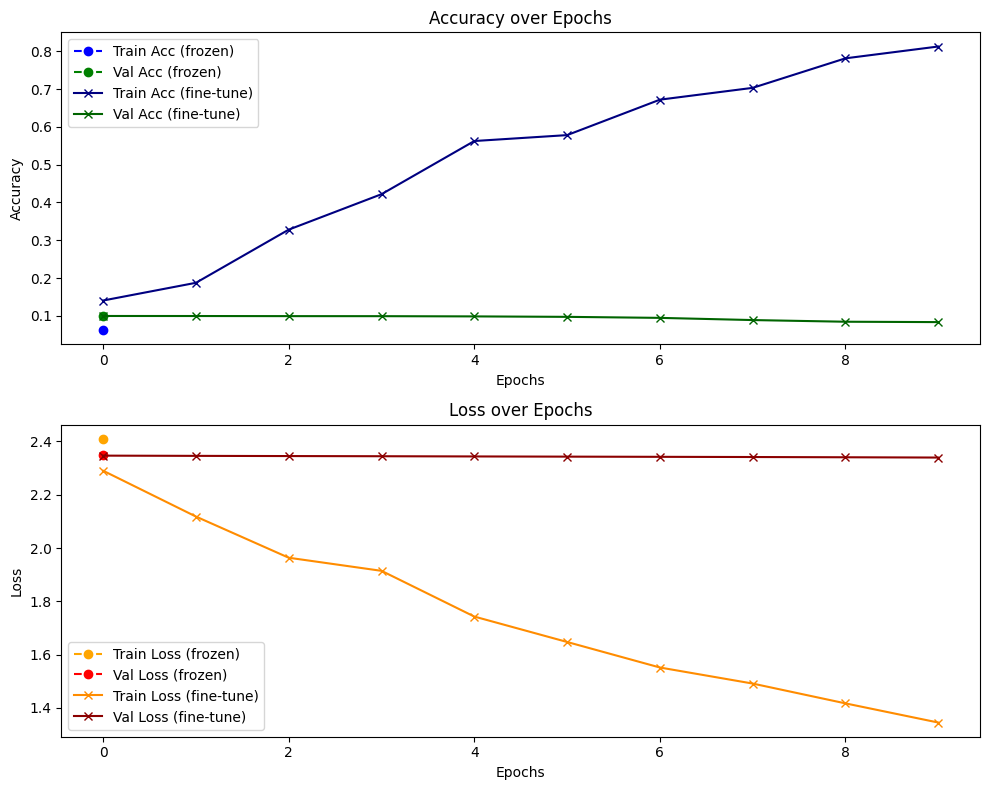

              model_name  frozen_accuracy_pct  fine_accuracy_pct  frozen_loss  \
0  128relu-drop04-64relu               0.0998             0.0997     2.347676   

   fine_loss  
0   2.339518  


In [24]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

results = run_experiment_v3(model, "128relu-drop04-64relu", base_model,
                            train_images, train_labels,
                            test_images, test_labels,frozen_epochs=1)


# Append the new result
all_results.append(results)

# Build the DataFrame
df_results = pd.DataFrame(all_results)

# Compute frozen/fine metrics from history
df_results['frozen_accuracy_pct'] = df_results['history_frozen'].apply(
    lambda h: h['val_accuracy'].max() if not h.empty else None)
df_results['frozen_loss'] = df_results['history_frozen'].apply(
    lambda h: h['val_loss'].min() if not h.empty else None)
df_results['fine_accuracy_pct'] = df_results['history_fine'].apply(
    lambda h: h['val_accuracy'].max())
df_results['fine_loss'] = df_results['history_fine'].apply(
    lambda h: h['val_loss'].min())

# Save to CSV after every run
df_results.to_csv("experiment_results.csv", index=False)

# Print current summary
print(df_results[["model_name", "frozen_accuracy_pct", "fine_accuracy_pct", "frozen_loss", "fine_loss"]])


"""Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
4/4 - 33s - 8s/step - accuracy: 0.0625 - loss: 2.4091 - val_accuracy: 0.0998 - val_loss: 2.3477
Frozen model saved to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu_frozen_20250822-193803.keras
Trainable layers for fine-tuning:
conv5_block1_1_conv
conv5_block1_1_bn
conv5_block1_1_relu
conv5_block1_2_conv
conv5_block1_2_bn
conv5_block1_2_relu
conv5_block1_0_conv
conv5_block1_3_conv
conv5_block1_0_bn
conv5_block1_3_bn
conv5_block1_add
conv5_block1_out
conv5_block2_1_conv
conv5_block2_1_bn
conv5_block2_1_relu
conv5_block2_2_conv
conv5_block2_2_bn
conv5_block2_2_relu
conv5_block2_3_conv
conv5_block2_3_bn
conv5_block2_add
conv5_block2_out
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
Epoch 1/10

Epoch 1: val_loss improved from inf to 2.34672, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu_best_finetune_20250822-193803.keras
4/4 - 44s - 11s/step - accuracy: 0.1406 - loss: 2.2900 - val_accuracy: 0.0997 - val_loss: 2.3467 - learning_rate: 1.0000e-05
Epoch 2/10

Epoch 2: val_loss improved from 2.34672 to 2.34585, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu_best_finetune_20250822-193803.keras
4/4 - 23s - 6s/step - accuracy: 0.1875 - loss: 2.1181 - val_accuracy: 0.0996 - val_loss: 2.3459 - learning_rate: 1.0000e-05
Epoch 3/10

Epoch 3: val_loss improved from 2.34585 to 2.34512, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu_best_finetune_20250822-193803.keras
4/4 - 9s - 2s/step - accuracy: 0.3281 - loss: 1.9636 - val_accuracy: 0.0993 - val_loss: 2.3451 - learning_rate: 1.0000e-05
Epoch 4/10

Epoch 4: val_loss improved from 2.34512 to 2.34446, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu_best_finetune_20250822-193803.keras
4/4 - 13s - 3s/step - accuracy: 0.4219 - loss: 1.9144 - val_accuracy: 0.0992 - val_loss: 2.3445 - learning_rate: 1.0000e-05
Epoch 5/10

Epoch 5: val_loss improved from 2.34446 to 2.34367, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu_best_finetune_20250822-193803.keras
4/4 - 20s - 5s/step - accuracy: 0.5625 - loss: 1.7429 - val_accuracy: 0.0986 - val_loss: 2.3437 - learning_rate: 1.0000e-05
Epoch 6/10

Epoch 6: val_loss improved from 2.34367 to 2.34295, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu_best_finetune_20250822-193803.keras
4/4 - 21s - 5s/step - accuracy: 0.5781 - loss: 1.6475 - val_accuracy: 0.0974 - val_loss: 2.3430 - learning_rate: 1.0000e-05
Epoch 7/10

Epoch 7: val_loss improved from 2.34295 to 2.34225, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu_best_finetune_20250822-193803.keras
4/4 - 20s - 5s/step - accuracy: 0.6719 - loss: 1.5517 - val_accuracy: 0.0947 - val_loss: 2.3423 - learning_rate: 1.0000e-05
Epoch 8/10

Epoch 8: val_loss improved from 2.34225 to 2.34150, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu_best_finetune_20250822-193803.keras
4/4 - 21s - 5s/step - accuracy: 0.7031 - loss: 1.4915 - val_accuracy: 0.0889 - val_loss: 2.3415 - learning_rate: 1.0000e-05
Epoch 9/10

Epoch 9: val_loss improved from 2.34150 to 2.34058, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu_best_finetune_20250822-193803.keras
4/4 - 20s - 5s/step - accuracy: 0.7812 - loss: 1.4171 - val_accuracy: 0.0845 - val_loss: 2.3406 - learning_rate: 1.0000e-05
Epoch 10/10

Epoch 10: val_loss improved from 2.34058 to 2.33952, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu_best_finetune_20250822-193803.keras
4/4 - 16s - 4s/step - accuracy: 0.8125 - loss: 1.3452 - val_accuracy: 0.0835 - val_loss: 2.3395 - learning_rate: 1.0000e-05

              model_name  frozen_accuracy_pct  fine_accuracy_pct  frozen_loss  \
0  128relu-drop04-64relu               0.0998             0.0997     2.347676

   fine_loss
0   2.339518  """

Epoch 1/10
4/4 - 51s - 13s/step - accuracy: 0.1094 - loss: 2.4356 - val_accuracy: 0.1000 - val_loss: 2.3527
Epoch 2/10
4/4 - 59s - 15s/step - accuracy: 0.0625 - loss: 2.3391 - val_accuracy: 0.0965 - val_loss: 2.3592
Epoch 3/10
4/4 - 41s - 10s/step - accuracy: 0.2188 - loss: 2.3070 - val_accuracy: 0.1000 - val_loss: 2.3702
Epoch 4/10
4/4 - 21s - 5s/step - accuracy: 0.1094 - loss: 2.2555 - val_accuracy: 0.1000 - val_loss: 2.3773
Frozen model saved to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu-lr1e-6_frozen_20250822-194214.keras
Trainable layers for fine-tuning:
conv5_block1_1_conv
conv5_block1_1_bn
conv5_block1_1_relu
conv5_block1_2_conv
conv5_block1_2_bn
conv5_block1_2_relu
conv5_block1_0_conv
conv5_block1_3_conv
conv5_block1_0_bn
conv5_block1_3_bn
conv5_block1_add
conv5_block1_out
conv5_block2_1_conv
conv5_block2_1_bn
conv5_block2_1_relu
conv5_block2_2_conv
conv5_block2_2_bn
conv5_block2_2_relu
con

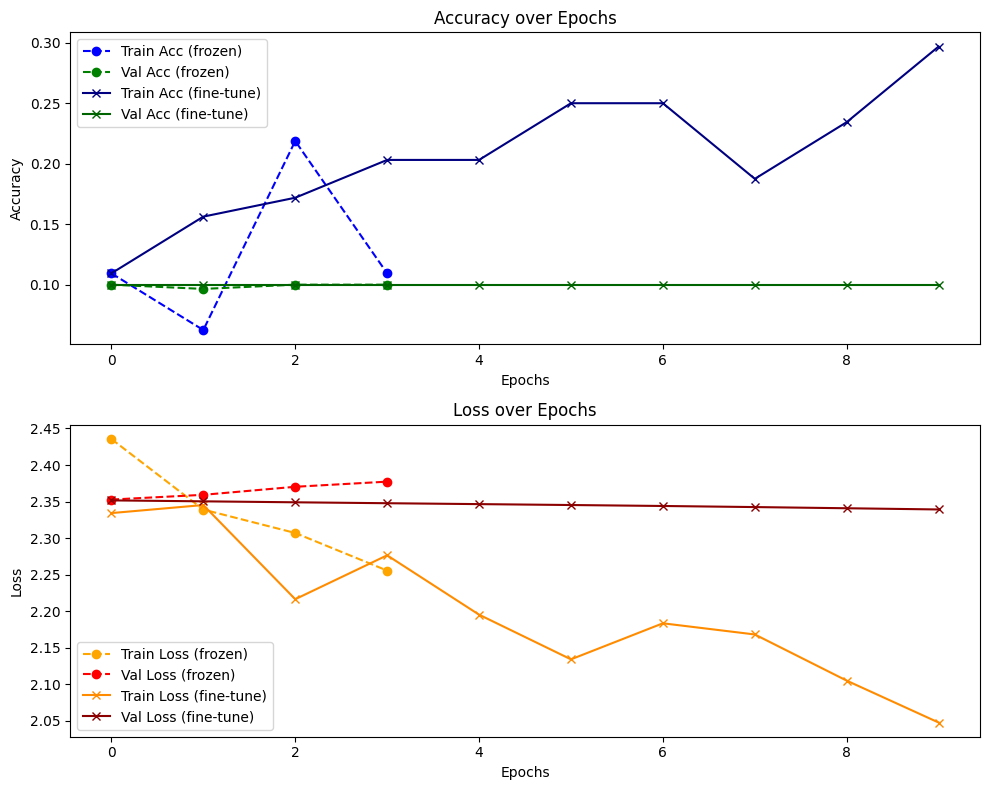

                     model_name  frozen_accuracy_pct  fine_accuracy_pct  \
0         128relu-drop04-64relu               0.0998             0.0997   
1  128relu-drop04-64relu-lr1e-6               0.1000             0.1000   

   frozen_loss  fine_loss  
0     2.347676   2.339518  
1     2.352746   2.339181  


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

results = run_experiment_v3(model, "128relu-drop04-64relu-lr1e-6", base_model,
                            train_images, train_labels,
                            test_images, test_labels, fine_lr=1e-6)

# Append the new result
all_results.append(results)

# Build the DataFrame
df_results = pd.DataFrame(all_results)

# Compute frozen/fine metrics from history
df_results['frozen_accuracy_pct'] = df_results['history_frozen'].apply(
    lambda h: h['val_accuracy'].max() if not h.empty else None)
df_results['frozen_loss'] = df_results['history_frozen'].apply(
    lambda h: h['val_loss'].min() if not h.empty else None)
df_results['fine_accuracy_pct'] = df_results['history_fine'].apply(
    lambda h: h['val_accuracy'].max())
df_results['fine_loss'] = df_results['history_fine'].apply(
    lambda h: h['val_loss'].min())

# Save to CSV after every run
df_results.to_csv("experiment_results.csv", index=False)

# Print current summary
print(df_results[["model_name", "frozen_accuracy_pct", "fine_accuracy_pct", "frozen_loss", "fine_loss"]])

"""Epoch 1/10
4/4 - 51s - 13s/step - accuracy: 0.1094 - loss: 2.4356 - val_accuracy: 0.1000 - val_loss: 2.3527
Epoch 2/10
4/4 - 59s - 15s/step - accuracy: 0.0625 - loss: 2.3391 - val_accuracy: 0.0965 - val_loss: 2.3592
Epoch 3/10
4/4 - 41s - 10s/step - accuracy: 0.2188 - loss: 2.3070 - val_accuracy: 0.1000 - val_loss: 2.3702
Epoch 4/10
4/4 - 21s - 5s/step - accuracy: 0.1094 - loss: 2.2555 - val_accuracy: 0.1000 - val_loss: 2.3773
Frozen model saved to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu-lr1e-6_frozen_20250822-194214.keras
Trainable layers for fine-tuning:
conv5_block1_1_conv
conv5_block1_1_bn
conv5_block1_1_relu
conv5_block1_2_conv
conv5_block1_2_bn
conv5_block1_2_relu
conv5_block1_0_conv
conv5_block1_3_conv
conv5_block1_0_bn
conv5_block1_3_bn
conv5_block1_add
conv5_block1_out
conv5_block2_1_conv
conv5_block2_1_bn
conv5_block2_1_relu
conv5_block2_2_conv
conv5_block2_2_bn
conv5_block2_2_relu
conv5_block2_3_conv
conv5_block2_3_bn
conv5_block2_add
conv5_block2_out
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
Epoch 1/10

Epoch 1: val_loss improved from inf to 2.35160, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu-lr1e-6_best_finetune_20250822-194214.keras
4/4 - 42s - 11s/step - accuracy: 0.1094 - loss: 2.3342 - val_accuracy: 0.1000 - val_loss: 2.3516 - learning_rate: 1.0000e-06
Epoch 2/10

Epoch 2: val_loss improved from 2.35160 to 2.35031, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu-lr1e-6_best_finetune_20250822-194214.keras
4/4 - 33s - 8s/step - accuracy: 0.1562 - loss: 2.3452 - val_accuracy: 0.1000 - val_loss: 2.3503 - learning_rate: 1.0000e-06
Epoch 3/10

Epoch 3: val_loss improved from 2.35031 to 2.34899, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu-lr1e-6_best_finetune_20250822-194214.keras
4/4 - 41s - 10s/step - accuracy: 0.1719 - loss: 2.2164 - val_accuracy: 0.1000 - val_loss: 2.3490 - learning_rate: 1.0000e-06
Epoch 4/10

Epoch 4: val_loss improved from 2.34899 to 2.34772, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu-lr1e-6_best_finetune_20250822-194214.keras
4/4 - 32s - 8s/step - accuracy: 0.2031 - loss: 2.2765 - val_accuracy: 0.1000 - val_loss: 2.3477 - learning_rate: 1.0000e-06
Epoch 5/10

Epoch 5: val_loss improved from 2.34772 to 2.34650, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu-lr1e-6_best_finetune_20250822-194214.keras
4/4 - 21s - 5s/step - accuracy: 0.2031 - loss: 2.1952 - val_accuracy: 0.1000 - val_loss: 2.3465 - learning_rate: 1.0000e-06
Epoch 6/10

Epoch 6: val_loss improved from 2.34650 to 2.34526, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu-lr1e-6_best_finetune_20250822-194214.keras
4/4 - 26s - 6s/step - accuracy: 0.2500 - loss: 2.1341 - val_accuracy: 0.1000 - val_loss: 2.3453 - learning_rate: 1.0000e-06
Epoch 7/10

Epoch 7: val_loss improved from 2.34526 to 2.34395, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu-lr1e-6_best_finetune_20250822-194214.keras
4/4 - 18s - 5s/step - accuracy: 0.2500 - loss: 2.1834 - val_accuracy: 0.1000 - val_loss: 2.3439 - learning_rate: 1.0000e-06
Epoch 8/10

Epoch 8: val_loss improved from 2.34395 to 2.34246, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu-lr1e-6_best_finetune_20250822-194214.keras
4/4 - 26s - 7s/step - accuracy: 0.1875 - loss: 2.1681 - val_accuracy: 0.1000 - val_loss: 2.3425 - learning_rate: 1.0000e-06
Epoch 9/10

Epoch 9: val_loss improved from 2.34246 to 2.34084, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu-lr1e-6_best_finetune_20250822-194214.keras
4/4 - 46s - 11s/step - accuracy: 0.2344 - loss: 2.1049 - val_accuracy: 0.1000 - val_loss: 2.3408 - learning_rate: 1.0000e-06
Epoch 10/10

Epoch 10: val_loss improved from 2.34084 to 2.33918, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu-lr1e-6_best_finetune_20250822-194214.keras
4/4 - 41s - 10s/step - accuracy: 0.2969 - loss: 2.0476 - val_accuracy: 0.1000 - val_loss: 2.3392 - learning_rate: 1.0000e-06

                     model_name  frozen_accuracy_pct  fine_accuracy_pct  \
0         128relu-drop04-64relu               0.0998             0.0997
1  128relu-drop04-64relu-lr1e-6               0.1000             0.1000

   frozen_loss  fine_loss
0     2.347676   2.339518
1     2.352746   2.339181  """

## v2-Run1

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
625/625 - 41s - 66ms/step - accuracy: 0.1037 - loss: 2.3095 - val_accuracy: 0.1026 - val_loss: 2.3020
Frozen model saved to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu_frozen_20250822-200419.keras
Trainable layers for fine-tuning:
conv5_block1_1_conv
conv5_block1_1_bn
conv5_block1_1_relu
conv5_block1_2_conv
conv5_block1_2_bn
conv5_block1_2_relu
conv5_block1_0_conv
conv5_block1_3_conv
conv5_block1_0_bn
conv5_block1_3_bn
conv5_block1_add
conv5_block1_out
conv5_block2_1_conv
conv5_block2_1_bn
conv5_block2_1_relu
conv5_block2_2_conv
conv5_block2_2_bn
conv5_block2_2_relu
conv5_block2_3_conv
conv5_block2_3_bn
conv5_block2_add
conv5_block2_out
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
Epoch 1/10

Epoch 1: val_los

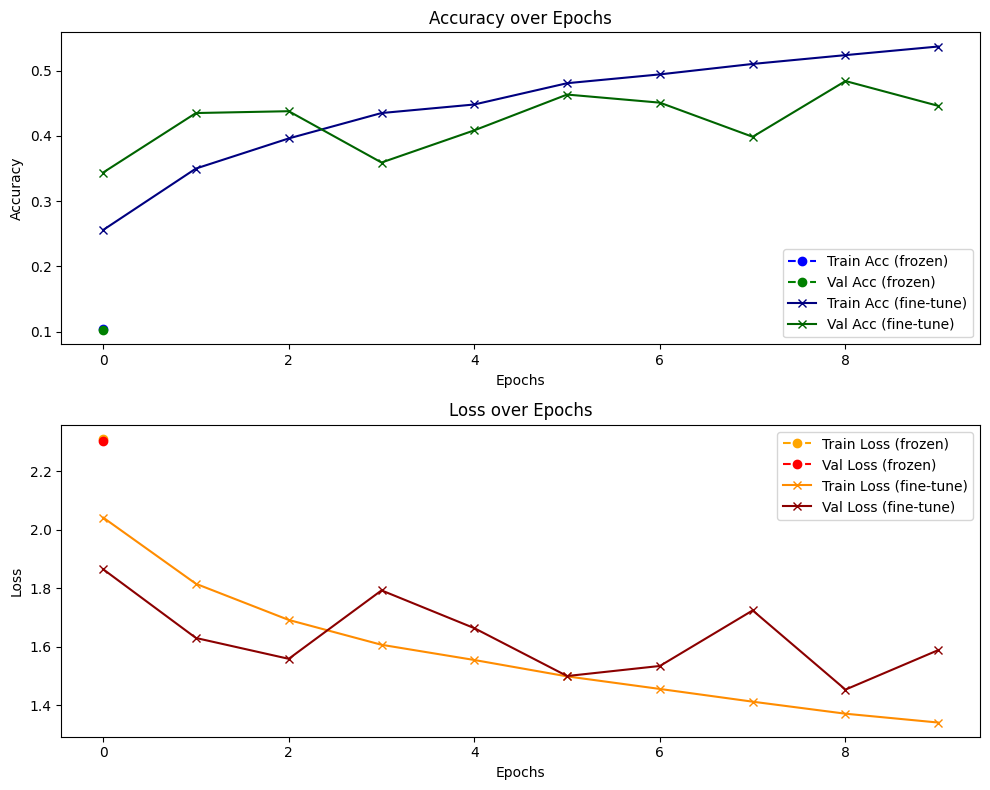

              model_name  frozen_accuracy_pct  fine_accuracy_pct  frozen_loss  \
0  128relu-drop04-64relu               0.1026              0.484     2.302016   

   fine_loss  
0   1.454172  


In [24]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

results = run_experiment_v3(model, "128relu-drop04-64relu", base_model,
                            train_images, train_labels,
                            test_images, test_labels,frozen_epochs=1)


# Append the new result
all_results.append(results)

# Build the DataFrame
df_results = pd.DataFrame(all_results)

# Compute frozen/fine metrics from history
df_results['frozen_accuracy_pct'] = df_results['history_frozen'].apply(
    lambda h: h['val_accuracy'].max() if not h.empty else None)
df_results['frozen_loss'] = df_results['history_frozen'].apply(
    lambda h: h['val_loss'].min() if not h.empty else None)
df_results['fine_accuracy_pct'] = df_results['history_fine'].apply(
    lambda h: h['val_accuracy'].max())
df_results['fine_loss'] = df_results['history_fine'].apply(
    lambda h: h['val_loss'].min())

# Save to CSV after every run
df_results.to_csv(results_csv_path, index=False)
print(f"Experiment results saved to {results_csv_path}")

# Print current summary
print(df_results[["model_name", "frozen_accuracy_pct", "fine_accuracy_pct", "frozen_loss", "fine_loss"]])


"""Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
625/625 - 41s - 66ms/step - accuracy: 0.1037 - loss: 2.3095 - val_accuracy: 0.1026 - val_loss: 2.3020
Frozen model saved to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu_frozen_20250822-200419.keras
Trainable layers for fine-tuning:
conv5_block1_1_conv
conv5_block1_1_bn
conv5_block1_1_relu
conv5_block1_2_conv
conv5_block1_2_bn
conv5_block1_2_relu
conv5_block1_0_conv
conv5_block1_3_conv
conv5_block1_0_bn
conv5_block1_3_bn
conv5_block1_add
conv5_block1_out
conv5_block2_1_conv
conv5_block2_1_bn
conv5_block2_1_relu
conv5_block2_2_conv
conv5_block2_2_bn
conv5_block2_2_relu
conv5_block2_3_conv
conv5_block2_3_bn
conv5_block2_add
conv5_block2_out
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
Epoch 1/10

Epoch 1: val_loss improved from inf to 1.86498, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu_best_finetune_20250822-200419.keras
625/625 - 61s - 98ms/step - accuracy: 0.2559 - loss: 2.0414 - val_accuracy: 0.3439 - val_loss: 1.8650 - learning_rate: 1.0000e-05
Epoch 2/10

Epoch 2: val_loss improved from 1.86498 to 1.63033, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu_best_finetune_20250822-200419.keras
625/625 - 59s - 95ms/step - accuracy: 0.3500 - loss: 1.8153 - val_accuracy: 0.4350 - val_loss: 1.6303 - learning_rate: 1.0000e-05
Epoch 3/10

Epoch 3: val_loss improved from 1.63033 to 1.55923, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu_best_finetune_20250822-200419.keras
625/625 - 53s - 85ms/step - accuracy: 0.3961 - loss: 1.6919 - val_accuracy: 0.4378 - val_loss: 1.5592 - learning_rate: 1.0000e-05
Epoch 4/10

Epoch 4: val_loss did not improve from 1.55923
625/625 - 24s - 38ms/step - accuracy: 0.4350 - loss: 1.6072 - val_accuracy: 0.3592 - val_loss: 1.7928 - learning_rate: 1.0000e-05
Epoch 5/10

Epoch 5: val_loss did not improve from 1.55923
625/625 - 40s - 64ms/step - accuracy: 0.4481 - loss: 1.5552 - val_accuracy: 0.4085 - val_loss: 1.6639 - learning_rate: 1.0000e-05
Epoch 6/10

Epoch 6: val_loss improved from 1.55923 to 1.50048, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu_best_finetune_20250822-200419.keras
625/625 - 41s - 65ms/step - accuracy: 0.4807 - loss: 1.4993 - val_accuracy: 0.4633 - val_loss: 1.5005 - learning_rate: 1.0000e-05
Epoch 7/10

Epoch 7: val_loss did not improve from 1.50048
625/625 - 21s - 34ms/step - accuracy: 0.4942 - loss: 1.4564 - val_accuracy: 0.4509 - val_loss: 1.5348 - learning_rate: 1.0000e-05
Epoch 8/10

Epoch 8: val_loss did not improve from 1.50048
625/625 - 35s - 57ms/step - accuracy: 0.5102 - loss: 1.4129 - val_accuracy: 0.3986 - val_loss: 1.7244 - learning_rate: 1.0000e-05
Epoch 9/10

Epoch 9: val_loss improved from 1.50048 to 1.45417, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu_best_finetune_20250822-200419.keras
625/625 - 46s - 73ms/step - accuracy: 0.5237 - loss: 1.3719 - val_accuracy: 0.4840 - val_loss: 1.4542 - learning_rate: 1.0000e-05
Epoch 10/10

Epoch 10: val_loss did not improve from 1.45417
625/625 - 21s - 34ms/step - accuracy: 0.5369 - loss: 1.3417 - val_accuracy: 0.4460 - val_loss: 1.5889 - learning_rate: 1.0000e-05

              model_name  frozen_accuracy_pct  fine_accuracy_pct  frozen_loss  \
0  128relu-drop04-64relu               0.1026              0.484     2.302016

   fine_loss
0   1.454172  """

## v2-Run2

Epoch 1/10
625/625 - 40s - 64ms/step - accuracy: 0.1050 - loss: 2.3085 - val_accuracy: 0.1378 - val_loss: 2.2980
Epoch 2/10
625/625 - 24s - 39ms/step - accuracy: 0.1135 - loss: 2.2929 - val_accuracy: 0.1641 - val_loss: 2.2695
Epoch 3/10
625/625 - 16s - 26ms/step - accuracy: 0.1482 - loss: 2.2515 - val_accuracy: 0.1873 - val_loss: 2.2041
Epoch 4/10
625/625 - 11s - 18ms/step - accuracy: 0.1745 - loss: 2.1869 - val_accuracy: 0.2043 - val_loss: 2.1203
Epoch 5/10
625/625 - 12s - 20ms/step - accuracy: 0.1905 - loss: 2.1494 - val_accuracy: 0.2081 - val_loss: 2.1056
Epoch 6/10
625/625 - 19s - 30ms/step - accuracy: 0.1935 - loss: 2.1309 - val_accuracy: 0.2335 - val_loss: 2.0545
Epoch 7/10
625/625 - 11s - 18ms/step - accuracy: 0.1972 - loss: 2.1236 - val_accuracy: 0.2274 - val_loss: 2.0604
Epoch 8/10
625/625 - 11s - 18ms/step - accuracy: 0.2075 - loss: 2.1077 - val_accuracy: 0.2497 - val_loss: 2.0131
Epoch 9/10
625/625 - 11s - 18ms/step - accuracy: 0.2069 - loss: 2.0971 - val_accuracy: 0.2475 - 

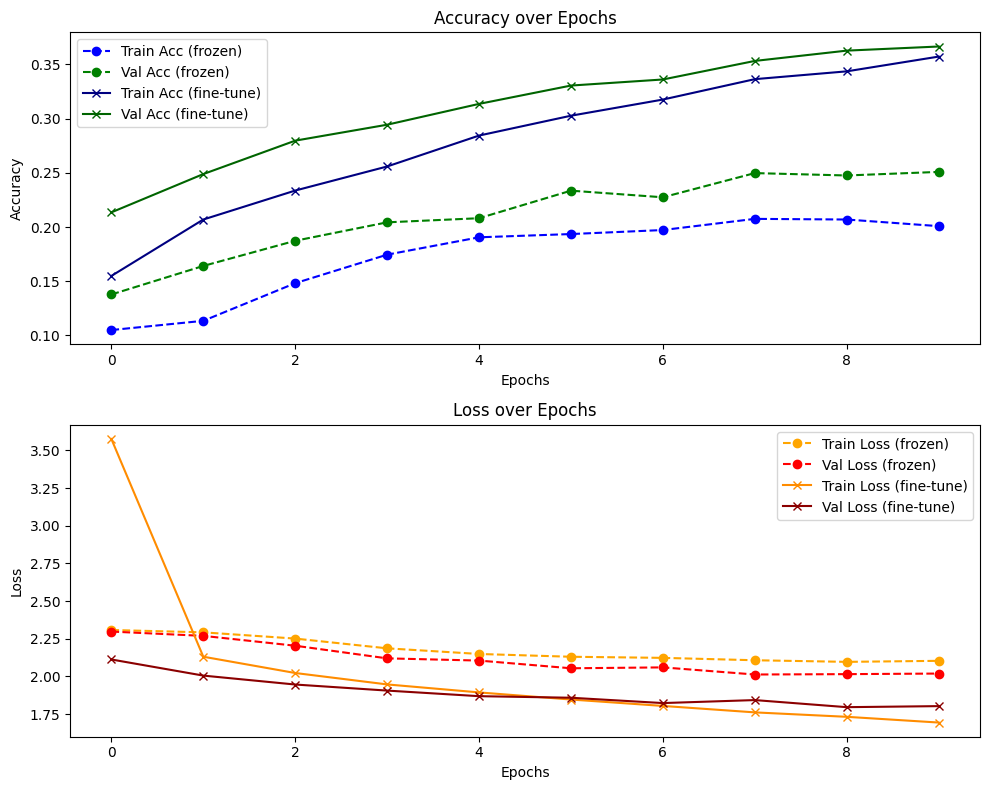

Experiment results saved to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/experiment_result.csv
                     model_name  frozen_accuracy_pct  fine_accuracy_pct  \
0  128relu-drop04-64relu-lr1e-6               0.2508             0.3664   

   frozen_loss  fine_loss  
0     2.013093   1.796375  


In [25]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

results = run_experiment_v3(model, "128relu-drop04-64relu-lr1e-6", base_model,
                            train_images, train_labels,
                            test_images, test_labels, fine_lr=1e-6)

# Append the new result
all_results.append(results)

# Build the DataFrame
df_results = pd.DataFrame(all_results)

# Compute frozen/fine metrics from history
df_results['frozen_accuracy_pct'] = df_results['history_frozen'].apply(
    lambda h: h['val_accuracy'].max() if not h.empty else None)
df_results['frozen_loss'] = df_results['history_frozen'].apply(
    lambda h: h['val_loss'].min() if not h.empty else None)
df_results['fine_accuracy_pct'] = df_results['history_fine'].apply(
    lambda h: h['val_accuracy'].max())
df_results['fine_loss'] = df_results['history_fine'].apply(
    lambda h: h['val_loss'].min())

# Save to CSV after every run
df_results.to_csv(results_csv_path, index=False)
print(f"Experiment results saved to {results_csv_path}")

# Print current summary
print(df_results[["model_name", "frozen_accuracy_pct", "fine_accuracy_pct", "frozen_loss", "fine_loss"]])


"""Epoch 1/10
625/625 - 40s - 64ms/step - accuracy: 0.1050 - loss: 2.3085 - val_accuracy: 0.1378 - val_loss: 2.2980
Epoch 2/10
625/625 - 24s - 39ms/step - accuracy: 0.1135 - loss: 2.2929 - val_accuracy: 0.1641 - val_loss: 2.2695
Epoch 3/10
625/625 - 16s - 26ms/step - accuracy: 0.1482 - loss: 2.2515 - val_accuracy: 0.1873 - val_loss: 2.2041
Epoch 4/10
625/625 - 11s - 18ms/step - accuracy: 0.1745 - loss: 2.1869 - val_accuracy: 0.2043 - val_loss: 2.1203
Epoch 5/10
625/625 - 12s - 20ms/step - accuracy: 0.1905 - loss: 2.1494 - val_accuracy: 0.2081 - val_loss: 2.1056
Epoch 6/10
625/625 - 19s - 30ms/step - accuracy: 0.1935 - loss: 2.1309 - val_accuracy: 0.2335 - val_loss: 2.0545
Epoch 7/10
625/625 - 11s - 18ms/step - accuracy: 0.1972 - loss: 2.1236 - val_accuracy: 0.2274 - val_loss: 2.0604
Epoch 8/10
625/625 - 11s - 18ms/step - accuracy: 0.2075 - loss: 2.1077 - val_accuracy: 0.2497 - val_loss: 2.0131
Epoch 9/10
625/625 - 11s - 18ms/step - accuracy: 0.2069 - loss: 2.0971 - val_accuracy: 0.2475 - val_loss: 2.0155
Epoch 10/10
625/625 - 11s - 18ms/step - accuracy: 0.2008 - loss: 2.1039 - val_accuracy: 0.2508 - val_loss: 2.0194
Frozen model saved to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu-lr1e-6_frozen_20250822-201746.keras
Trainable layers for fine-tuning:
conv5_block1_1_conv
conv5_block1_1_bn
conv5_block1_1_relu
conv5_block1_2_conv
conv5_block1_2_bn
conv5_block1_2_relu
conv5_block1_0_conv
conv5_block1_3_conv
conv5_block1_0_bn
conv5_block1_3_bn
conv5_block1_add
conv5_block1_out
conv5_block2_1_conv
conv5_block2_1_bn
conv5_block2_1_relu
conv5_block2_2_conv
conv5_block2_2_bn
conv5_block2_2_relu
conv5_block2_3_conv
conv5_block2_3_bn
conv5_block2_add
conv5_block2_out
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
Epoch 1/10

Epoch 1: val_loss improved from inf to 2.11282, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu-lr1e-6_best_finetune_20250822-201746.keras
625/625 - 81s - 129ms/step - accuracy: 0.1549 - loss: 3.5759 - val_accuracy: 0.2135 - val_loss: 2.1128 - learning_rate: 1.0000e-06
Epoch 2/10

Epoch 2: val_loss improved from 2.11282 to 2.00588, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu-lr1e-6_best_finetune_20250822-201746.keras
625/625 - 41s - 66ms/step - accuracy: 0.2069 - loss: 2.1312 - val_accuracy: 0.2488 - val_loss: 2.0059 - learning_rate: 1.0000e-06
Epoch 3/10

Epoch 3: val_loss improved from 2.00588 to 1.94661, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu-lr1e-6_best_finetune_20250822-201746.keras
625/625 - 43s - 68ms/step - accuracy: 0.2336 - loss: 2.0231 - val_accuracy: 0.2796 - val_loss: 1.9466 - learning_rate: 1.0000e-06
Epoch 4/10

Epoch 4: val_loss improved from 1.94661 to 1.90641, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu-lr1e-6_best_finetune_20250822-201746.keras
625/625 - 88s - 141ms/step - accuracy: 0.2558 - loss: 1.9473 - val_accuracy: 0.2943 - val_loss: 1.9064 - learning_rate: 1.0000e-06
Epoch 5/10

Epoch 5: val_loss improved from 1.90641 to 1.86931, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu-lr1e-6_best_finetune_20250822-201746.keras
625/625 - 80s - 128ms/step - accuracy: 0.2843 - loss: 1.8942 - val_accuracy: 0.3135 - val_loss: 1.8693 - learning_rate: 1.0000e-06
Epoch 6/10

Epoch 6: val_loss improved from 1.86931 to 1.85889, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu-lr1e-6_best_finetune_20250822-201746.keras
625/625 - 76s - 121ms/step - accuracy: 0.3026 - loss: 1.8470 - val_accuracy: 0.3304 - val_loss: 1.8589 - learning_rate: 1.0000e-06
Epoch 7/10

Epoch 7: val_loss improved from 1.85889 to 1.82355, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu-lr1e-6_best_finetune_20250822-201746.keras
625/625 - 85s - 136ms/step - accuracy: 0.3175 - loss: 1.8046 - val_accuracy: 0.3360 - val_loss: 1.8236 - learning_rate: 1.0000e-06
Epoch 8/10

Epoch 8: val_loss did not improve from 1.82355
625/625 - 58s - 92ms/step - accuracy: 0.3363 - loss: 1.7618 - val_accuracy: 0.3531 - val_loss: 1.8434 - learning_rate: 1.0000e-06
Epoch 9/10

Epoch 9: val_loss improved from 1.82355 to 1.79637, saving model to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/128relu-drop04-64relu-lr1e-6_best_finetune_20250822-201746.keras
625/625 - 44s - 70ms/step - accuracy: 0.3435 - loss: 1.7323 - val_accuracy: 0.3626 - val_loss: 1.7964 - learning_rate: 1.0000e-06
Epoch 10/10

Epoch 10: val_loss did not improve from 1.79637
625/625 - 53s - 85ms/step - accuracy: 0.3571 - loss: 1.6943 - val_accuracy: 0.3664 - val_loss: 1.8033 - learning_rate: 1.0000e-06

Experiment results saved to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/experiment_result.csv
                     model_name  frozen_accuracy_pct  fine_accuracy_pct  \
0  128relu-drop04-64relu-lr1e-6               0.2508             0.3664

   frozen_loss  fine_loss
0     2.013093   1.796375 """

# Model

## Model import

In [126]:
"""# Load the EfficientNetB0 model, excluding the top classification layers
base_model = ResNet50(weights='imagenet', include_top=False,
                            input_shape=(32, 32, 3))

# Freeze the base model to retain its pre-trained weights
base_model.trainable = False"""

"# Load the EfficientNetB0 model, excluding the top classification layers\nbase_model = ResNet50(weights='imagenet', include_top=False,\n                            input_shape=(32, 32, 3))\n\n# Freeze the base model to retain its pre-trained weights\nbase_model.trainable = False"

In [127]:
"""# Create a custom top layer
model = models.Sequential([
    base_model,
    # Converts the feature maps into a single vector
    layers.GlobalAveragePooling2D(),
    # Add a fully connected layer with 128 neurons
    layers.Dense(128, activation='relu'),
    # Add a second fully connected layer with 128 neurons
    layers.Dense(64, activation='relu'),
    # Final layer with 10 outputs for 10 classes
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])"""

"# Create a custom top layer\nmodel = models.Sequential([\n    base_model,\n    # Converts the feature maps into a single vector\n    layers.GlobalAveragePooling2D(),\n    # Add a fully connected layer with 128 neurons\n    layers.Dense(128, activation='relu'),\n    # Add a second fully connected layer with 128 neurons\n    layers.Dense(64, activation='relu'),\n    # Final layer with 10 outputs for 10 classes\n    layers.Dense(10, activation='softmax')\n])\n\n# Compile the model\nmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])"

In [128]:
"""# Train the model
history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images,
                    test_labels),batch_size=64,verbose=2)"""

'# Train the model\nhistory = model.fit(train_images, train_labels, epochs=10,\n                    validation_data=(test_images,\n                    test_labels),batch_size=64,verbose=2)'

## Model evaluation

In [129]:
"""# Evaluate the model on the test set
test_loss_1, test_accuracy_1 = model.evaluate(test_images,
       test_labels)
"""


'# Evaluate the model on the test set\ntest_loss_1, test_accuracy_1 = model.evaluate(test_images,\n       test_labels)\n'

In [130]:
#print(f"Test accuracy: {test_accuracy_1 * 100:.2f}")


## Base model Trainable

In [131]:
#base_model.trainable = True

In [132]:
"""model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
"""

"model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),\n              loss='categorical_crossentropy',\n              metrics=['accuracy'])\n"

In [133]:
"""# Train the model
history_fine = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images,
                    test_labels),batch_size=64,verbose=2)"""

'# Train the model\nhistory_fine = model.fit(train_images, train_labels, epochs=10,\n                    validation_data=(test_images,\n                    test_labels),batch_size=64,verbose=2)'

## Evaluation with base model Fine Tuning

In [134]:
"""# Evaluate the model on the test set
test_loss_fine, test_accuracy_fine = model.evaluate(test_images,
       test_labels)

"""

'# Evaluate the model on the test set\ntest_loss_fine, test_accuracy_fine = model.evaluate(test_images,\n       test_labels)\n\n'

In [135]:
#print(f"Test accuracy: {test_accuracy_fine * 100:.2f}")

In [ ]:
def run_experiment_v3(model, model_name, base_model,
                   train_images, train_labels,
                   test_images, test_labels,
                   batch_size=BATCH_SIZE,
                   frozen_lr=1e-3, fine_lr=1e-5,
                   frozen_epochs=10, fine_epochs=10,
                   use_early_stop=True, monitor="val_loss", patience=3, min_delta=0.0):

    """
    Runs a two-phase experiment:
    1. Train head with frozen base
    2. Fine-tune with base unfrozen

    Args:
        model: compiled keras model with base_model included
        model_name: name string
        base_model: the backbone (e.g., ResNet50)
        train_images, train_labels: training data
        test_images, test_labels: validation/test data
        batch_size: training batch size
        frozen_lr: learning rate during frozen training
        fine_lr: learning rate during fine-tuning
        frozen_epochs: epochs for frozen training
        fine_epochs: epochs for fine-tuning
    """
    timestamp = time.strftime("%Y%m%d-%H%M%S")



    callbacks_frozen = []
    if use_early_stop:
        callbacks_frozen.append(tf.keras.callbacks.EarlyStopping(
            monitor=monitor,
            patience=patience,
            min_delta=min_delta,
            restore_best_weights=True
        ))


    # --- Phase 1: Train head (frozen base) ---
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=frozen_lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_images, train_labels,
                        validation_data=(test_images, test_labels),
                        epochs=frozen_epochs, batch_size=batch_size,
                        verbose=2,
                        callbacks=callbacks_frozen)
    # --- Save history with pickle ---
    history_filename = f"{model_name}_history_frozen_{timestamp}.pkl"
    with open(history_filename, "wb") as f:
        pickle.dump(history.history, f)
    print(f"History saved to {history_filename}")

    hist_frozen = pd.DataFrame(history.history)
    del history

    # Check if early stopping was triggered
    for cb in callbacks_frozen:
        if isinstance(cb, tf.keras.callbacks.EarlyStopping):
            if cb.stopped_epoch > 0:
                print(f"Early stopping triggered at epoch {cb.stopped_epoch + 1}")
            else:
                print("Early stopping did not trigger.")


    temp_path_frozen = f"/content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/best_model_frozen_{model_name}_{timestamp}.keras"
    model.save(temp_path_frozen)
    print(f"Frozen model saved to {temp_path_frozen}")

    #test_loss_frozen, test_acc_frozen = model.evaluate(test_images, test_labels, verbose=0)

    #final_frozen_path = f"/content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/best_model_frozen__{model_name}_{timestamp}_ValAcc_{(test_acc_frozen*100):.2f}%.keras"
    #os.rename(temp_path_frozen, final_frozen_path)
    #print(f"Model renamed to {final_frozen_path}")

    del callbacks_frozen




    # --- Phase 2: Fine-tuning ---

    #base_model.trainable = True
    for layer in base_model.layers:
      if layer.name.startswith('conv5'):
          layer.trainable = True
      else:
          layer.trainable = False
    print("Trainable layers for fine-tuning:")
    for layer in model.layers[0].layers:  # base_model is model.layers[0]
        if layer.trainable:
            print(layer.name)


    callbacks_fine = []
    if use_early_stop:
        callbacks_fine.append(tf.keras.callbacks.EarlyStopping(
            monitor=monitor,
            patience=patience + 2,   # updated patience
            min_delta=min_delta,
            restore_best_weights=True
        ))


    callbacks_fine.extend([
        ReduceLROnPlateau(monitor=monitor, factor=0.5, patience=patience, verbose=1),
        CSVLogger(f'{model_name}_finetune_log.csv', append=True),
        ModelCheckpoint(f'{model_name}_best_finetune.h5', monitor=monitor,
                        save_best_only=True, verbose=1)
    ])

    # Add checkpoint callback
    """checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "best_model_fine.keras",
        monitor="val_accuracy",   # or "val_loss", depending on your goal
        save_best_only=True,
        mode="max"                # "max" for accuracy, "min" for loss
    )
    callbacks_fine.append(checkpoint)"""

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=fine_lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history_fine = model.fit(train_images, train_labels,
                             validation_data=(test_images, test_labels),
                             epochs=fine_epochs, batch_size=batch_size,
                             verbose=2,
                             callbacks=callbacks_fine)
    # --- Save history with pickle ---
    history_filename = f"{model_name}_history_fine_{timestamp}.pkl"
    with open(history_filename, "wb") as f:
        pickle.dump(history_fine.history, f)
    print(f"History saved to {history_filename}")

    hist_fine = pd.DataFrame(history_fine.history)
    del history_fine
    # Check if early stopping was triggered
    for cb in callbacks_fine:
        if isinstance(cb, tf.keras.callbacks.EarlyStopping):
            if cb.stopped_epoch > 0:
                print(f"Early stopping triggered at epoch {cb.stopped_epoch + 1}")
            else:
                print("Early stopping did not trigger.")


    temp_drive_path = f"/content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/best_model_fine_{model_name}_{timestamp}.keras"
    model.save(temp_drive_path)
    print(f"Model saved to {temp_drive_path}")

    test_loss_fine, test_acc_fine = model.evaluate(test_images, test_labels, verbose=0)

    #final_fine_path = f"/content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/best_model_fine_{model_name}_{timestamp}_ValAcc_{(test_acc_fine*100):.2f}%.keras"
    #model.save(final_drive_path)
    #print(f"Model saved to {final_fine_path}")

    # --- Plot results ---



    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Accuracy
    ax1.plot(hist_frozen['accuracy'], label='Train Acc (frozen)', color='blue', linestyle='--', marker='o')
    ax1.plot(hist_frozen['val_accuracy'], label='Val Acc (frozen)', color='green', linestyle='--', marker='o')
    ax1.plot(hist_fine['accuracy'], label='Train Acc (fine-tune)', color='navy', linestyle='-', marker='x')
    ax1.plot(hist_fine['val_accuracy'], label='Val Acc (fine-tune)', color='darkgreen', linestyle='-', marker='x')
    ax1.set_title('Accuracy over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Loss
    ax2.plot(hist_frozen['loss'], label='Train Loss (frozen)', color='orange', linestyle='--', marker='o')
    ax2.plot(hist_frozen['val_loss'], label='Val Loss (frozen)', color='red', linestyle='--', marker='o')
    ax2.plot(hist_fine['loss'], label='Train Loss (fine-tune)', color='darkorange', linestyle='-', marker='x')
    ax2.plot(hist_fine['val_loss'], label='Val Loss (fine-tune)', color='darkred', linestyle='-', marker='x')
    ax2.set_title('Loss over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # --- Collect results ---
    results = {
        "model_name": model_name,
        #"frozen_accuracy_pct": test_acc_frozen * 100,
        #"frozen_loss": test_loss_frozen,
        #"fine_accuracy_pct": test_acc_fine * 100,
        #"fine_loss": test_loss_fine,
        "history_frozen": hist_frozen,
        "history_fine": hist_fine
    }

    # 🔑 Clear memory
    K.clear_session()
    del model
    del base_model
    gc.collect()

    return results



In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

results = run_experiment_v2(model, "128relu-drop04-64relu", base_model,
                            train_images, train_labels,
                            test_images, test_labels,frozen_epochs=1)

all_results.append(results)

df_results = pd.DataFrame(all_results)
print(df_results[["model_name",
                  "frozen_accuracy_pct", "fine_accuracy_pct",
                  "frozen_loss", "fine_loss"]])

"""313/313 - 47s - 151ms/step - accuracy: 0.1104 - loss: 2.3088 - val_accuracy: 0.1028 - val_loss: 2.2971
Epoch 2/10
313/313 - 20s - 64ms/step - accuracy: 0.1244 - loss: 2.2875 - val_accuracy: 0.1475 - val_loss: 2.2579
Epoch 3/10
313/313 - 21s - 66ms/step - accuracy: 0.1552 - loss: 2.2379 - val_accuracy: 0.1963 - val_loss: 2.1838
Epoch 4/10
313/313 - 18s - 58ms/step - accuracy: 0.1794 - loss: 2.1767 - val_accuracy: 0.2261 - val_loss: 2.0908
Epoch 5/10
313/313 - 18s - 58ms/step - accuracy: 0.2034 - loss: 2.1158 - val_accuracy: 0.2464 - val_loss: 2.0322
Epoch 6/10
313/313 - 22s - 69ms/step - accuracy: 0.2113 - loss: 2.0890 - val_accuracy: 0.2563 - val_loss: 2.0181
Epoch 7/10
313/313 - 19s - 61ms/step - accuracy: 0.2115 - loss: 2.0780 - val_accuracy: 0.2606 - val_loss: 2.0006
Epoch 8/10
313/313 - 18s - 58ms/step - accuracy: 0.2212 - loss: 2.0565 - val_accuracy: 0.2629 - val_loss: 1.9826
Epoch 9/10
313/313 - 20s - 65ms/step - accuracy: 0.2277 - loss: 2.0466 - val_accuracy: 0.2699 - val_loss: 1.9731
Epoch 10/10
313/313 - 22s - 69ms/step - accuracy: 0.2269 - loss: 2.0324 - val_accuracy: 0.2722 - val_loss: 1.9491"""

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
4/4 - 31s - 8s/step - accuracy: 0.0625 - loss: 2.4091 - val_accuracy: 0.0998 - val_loss: 2.3477
Early stopping did not trigger.
Frozen model saved to /content/drive/MyDrive/2. Further Education/Masterschool/Computer Vision - Image processing/CV Project/Models/best_model_frozen_128relu-drop04-64relu_20250822-185101.keras
Trainable layers for fine-tuning:
conv5_block1_1_conv
conv5_block1_1_bn
conv5_block1_1_relu
conv5_block1_2_conv
conv5_block1_2_bn
conv5_block1_2_relu
conv5_block1_0_conv
conv5_block1_3_conv
conv5_block1_0_bn
conv5_block1_3_bn
conv5_block1_add
conv5_block1_out
conv5_block2_1_conv
conv5_block2_1_bn
conv5_block2_1_relu
conv5_block2_2_conv
conv5_block2_2_bn
conv5_block2_2_relu
conv5_block2_3_conv
conv5_block2_3_bn
conv5_block2_add
conv5_block2_out
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_bl

NameError: name 'callbacks_finetune' is not defined